# Introduction

This workbook is an introduction to the basic concepts and designs relating to the paper 

**Fast estimation of sparse quantum noise** by *Harper, Yu and Flammia*

This workbook is going to go through the basic ideas behind experimental design for a trivial 6 qubit system. 

### Initial things to note about the example

This is of marginal utility of only a 6 qubit system! There are only 4096 Paulis to measure in a 6 qubit system. The protocol requires a minimum number of 4n+2 experiments, each measuring (2^6) 64 possible outcomes. 26*64 = 1664 measurements - we can reconstruct all the Paulis for not much more than this! For this type of protocol we are assuming a $\delta$ of about $0.25$, ie $4^{0.25*6}$, so we are expecting that we will only be seeking to recover the 8-9 highest weight Paulis - obviously as system size increases that is where the algorithm shines. So for instance with the 14 qubit example, in a later workbook - it makes a lot more sense.

---
<div style="border: 3px solid red"><p style="padding:5px 10px 5px 10px;"><strong>Warning:</strong> As mentioned above this is a long and tedious workbook that is, ulitmately, in some sense disappointing. Because we simulate the entire experiment we can (and do) look at all the intermediate results. Six qubits takes about a minute to simulate a run, and we need to do 4*6+2 of them. At then end we get 8 (well often closer to 12) numbers that are *approximately* correct. I'll try and include a qiskit simulation, which will have a less realistic noise model - but will be more qubits. Then, of course, there is the work book which was used for the paper, it is based off actual 14 qubit experimental data and recovers a lot more information (because it is a bigger system). But if you want the whole gory detail, the system here is small enough to grasp everything that is happening but big enough to be not entirely trivial, although it's a lot of work for very little (because of the small size of the system).</p></div>

---

### Assumed knowledge 

The workbook assumes some familiarity with the basic decoder, which is detailed in the workbook Scalabale Estimate - Basic Concepts. Another starter workbook that might be useful is Hadamard Basics and Observations - which also goes through the Hadamard transform (there is some duplication) but then shows how it fits in with the SuperOperator representation, the impact of only being able to measure commuting Paulis (in the one experiment) and how that relates to the circuits we design and the measurements we make. We will be using these concepts in the circuits we simulate here, and I probably won't go through it again here.

Because we are simulating the experiments here it is a bit painful - but I wanted to have an exact noise model so we could check we were in fact recovering what we expectes. 

The other workbook released with the code will show how the algorithm performs in practice with data derived from an IBM Quantum Experience 14 qubit machine.

### This is the place to start if you want to understand how the local stabiliser circuits are formed and the various decoding bins collated.

I have left volumes and volumes of data in the cells. If you are trying to debug your own decoder - that will be helpful.




# Software needed 

For this introductory notebook, we need minimal software. All these packages should be available through the Julia package manager. However, we will need some to help with the simulation etc.

If you get an error trying to "use" them the error message tells you how to load them.

In [1]:
using Hadamard
using PyPlot
# convenience (type /otimes<tab>) - <tab> is the "tab" key.
⊗ = kron
# type /oplus<tab>
⊕ = (x,y)->mod.(x+y,2)


#3 (generic function with 1 method)

In [2]:
# I love this add on, especially as some of the simulations take a noticeable time. 
using ProgressMeter

In [3]:
# We are going to need some more of my code
# You can get it by doing the following, in the main julia repl (hit ']' to get to the package manager)
# pkg> add https://github.com/rharper2/Juqst.jl

# Currently there is harmless warning re overloading Hadamard.


using Juqst

In [4]:
# This is the code in this github that implements the various peeling algorithms for us.
include("peel.jl")

Main.PEEL

In [5]:
using Main.PEEL

# Some preliminary information.

## This is replicated from "Scalable Estimation - Basic Concepts"




## Conventions

### What's in a name?

There are a number of conventions as to where which qubit should be. Here we are going to adopt a least significant digit approach - which is different from the normal 'ket' approach.

So for example: IZ means and I 'Pauli' on qubit = 2 and a Z 'Pauli' on qubit = 1 (indexing off 1).

### Arrays indexed starting with 1.

For those less familiar with Julia, unlike - say - python all arrays and vectors are indexed off 1. Without going into the merits or otherwise of this, we just need to keep it in mind. With our bitstring the bitstring 0000 represents the two qubits II, it has value 0, but it will index the first value in our vector i.e. 1. 


### Representing Paulis with bitstrings.

There are many ways to represent Paulis with bit strings, including for instance the convention used in **Improved Simulation of Stabilizer Circuits**, *Scott Aaronson and Daniel Gottesman*, [arXiv:quant-ph/0406196v5](https://arxiv.org/abs/quant-ph/0406196v5).

Here we are going to use one that allows us to naturally translate the Pauli to its position in our vector of Pauli eigenvalues (of course this is arbitrary, we could map them however we like).

The mapping I am going to use is this (together with the least significant convention):

---

- I $\rightarrow$ 00
- X $\rightarrow$ 01
- Y $\rightarrow$ 10
- Z $\rightarrow$ 11


---


This then naturally translates as below:

### SuperOperator  - Pauli basis

We have defined our SuperOperator basis to be as below, which means with the julia vector starting at 1 we have : 

<table class="tg" style="font-size:large">
  <tr >
    <th style="text-align:center">Pauli</th>
    <th style="text-align:center">Vector Index</th>
    <th style="width:100px;text-align:center">---</th>
    <th style="text-align:center">Binary</th>
    <th style="text-align:center">Integer</th>
  </tr>
  <tr >
    <td style="text-align:center">II</td>
    <td style="text-align:center">1</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">0000</td>
    <td style="text-align:center">0</td>
  </tr>
  <tr>
    <td style="text-align:center">IX</td>
    <td style="text-align:center">2</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">0001</td>
    <td style="text-align:center">1</td>
  </tr>
  <tr>
    <td style="text-align:center">IY</td>
    <td style="text-align:center">3</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">0010</td>
    <td style="text-align:center">2</td>
  </tr>
      <tr>
    <td style="text-align:center">IZ</td>
    <td style="text-align:center">4</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">0011</td>
    <td style="text-align:center">3</td>
  </tr>
  <tr>
    <td style="text-align:center">XI</td>
    <td style="text-align:center">5</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">0100</td>
    <td style="text-align:center">4</td>
  </tr>
  <tr>
    <td style="text-align:center">XX</td>
    <td style="text-align:center">6</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">0101</td>
    <td style="text-align:center">5</td>
  </tr>
  <tr>
    <td style="text-align:center">XY</td>
    <td style="text-align:center">7</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">0110</td>
    <td style="text-align:center">6</td>
  </tr>
  <tr>
    <td style="text-align:center">XZ</td>
    <td style="text-align:center">8</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">0111</td>
    <td style="text-align:center">7</td>
  </tr>
  <tr>
    <td style="text-align:center">YI</td>
    <td style="text-align:center">9</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">1000</td>
    <td style="text-align:center">8</td>
  </tr>
  <tr>
    <td style="text-align:center">YX</td>
    <td style="text-align:center">10</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">1001</td>
    <td style="text-align:center">9</td>
  </tr>
  <tr>
    <td style="text-align:center">YY</td>
    <td style="text-align:center">11</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">1010</td>
    <td style="text-align:center">10</td>
  </tr>
  <tr>
    <td style="text-align:center">YZ</td>
    <td style="text-align:center">12</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">1011</td>
    <td style="text-align:center">11</td>
  </tr>
  <tr>
    <td style="text-align:center">ZI</td>
    <td style="text-align:center">13</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">1100</td>
    <td style="text-align:center">12</td>
  </tr>
  <tr>
    <td style="text-align:center">ZX</td>
    <td style="text-align:center">14</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">1101</td>
    <td style="text-align:center">13</td>
  </tr>
  <tr>
    <td style="text-align:center">ZY</td>
    <td style="text-align:center">15</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">1110</td>
    <td style="text-align:center">14</td>
  </tr>
      <tr>
    <td style="text-align:center">ZZ</td>
    <td style="text-align:center">16</td>
    <td style="width:100px;text-align:center">→</td>
    <td style="text-align:center">1111</td>
    <td style="text-align:center">15</td>
  </tr>


</table>

I have set this out in painful detail, because its important to understand the mapping for the rest to make sense.

So for instance in our EIGENVALUE vector (think superoperator diagonal), the PAUL YX has binary representation Y=10 X=01, therefore 1001, has "binary-value" 9 and is the 10th (9+1) entry in our eigenvalue vector.

## What's in a Walsh Hadamard Transform?

The standard Walsh-Hadmard transform is based off tensor (Kronecker) products of the following matrix:

$$\left(\begin{array}{cc}1 & 1\\1 & -1\end{array}\right)^{\otimes n}$$

### WHT_natural

So for one qubit it would be:

$\begin{array}{cc}
& \begin{array}{cccc} \quad 00 &  \quad 01 & \quad 10  &\quad 11 \end{array}\\
\begin{array}{c} 00\\ 01\\ 10\\11\end{array} &
  \left(\begin{array}{cccc}
   \quad 1&\quad 1& \quad 1 &\quad 1\\
   \quad 1 &\quad -1 & \quad 1 &\quad -1\\   \quad 1&\quad 1 & \quad -1 &\quad -1\\   \quad 1 &\quad -1 & \quad -1 &\quad 1\\\end{array}\right)
\end{array}$

where I have included above (and to the left) of the transform matrix the binary representations of the position and the matrix can also be calculated as $(-1)^{\langle i,j\rangle}$ where the inner product here is the binary inner product $i,j\in\mathbb{F}_2^n$ as $\langle i,j\rangle=\sum^{n-1}_{t=0}i[t]j[t]$ with arithmetic over $\mathbb{F}_2$ 

### WHT_Pauli

In the paper we use a different form of the Walsh-Hadamard transform. In this case we use the inner product of the Paulis, not the 'binary bitstring' inner product. The matrix is subtly different some rows or, if you prefer, columns are swapped:

$\begin{array}{cc}
& \begin{array}{cccc} I(00) &  X(01) & Y(10)  & Z(11) \end{array}\\
\begin{array}{c} I(00)\\ X(01)\\ Y(10)\\Z(11)\end{array} &
  \left(\begin{array}{cccc}
   \quad 1&\quad 1& \quad 1 &\quad 1\\
   \quad 1 &\quad 1 & \quad -1 &\quad -1\\   \quad 1&\quad -1 & \quad 1 &\quad -1\\   \quad 1 &\quad -1 & \quad -1 &\quad 1\\\end{array}\right)
\end{array}$


### Which one to use

When transforming Pauli eigenvalue to the probability of a particular error occuring, there are distinct advantages in using the WHT_Pauli transform. The order of the Pauli errors and the order of the Pauli eigenvalues remains the same. However, most common packages (including the one we are going to use here in Julia) don't support this type of transform, rather they implement the WHT_natural transform. The WHT_natural transform also makes the peeling algorithm slightly less fiddly. **However** it does mean we need to be very careful about the order of things. If we use the WHT_natural transform then the following relationship holds - *note the indices (labels) of the Paulis in the probability vector*:


![Example of Index change](./figures/HadamardNa.jpg)

So the natural translation (labelling of Paulis) then becomes as follows:

### Eigenvalue vector space ###


- I $\rightarrow$ 00
- X $\rightarrow$ 01
- Y $\rightarrow$ 10
- Z $\rightarrow$ 11

### Probability vector space ###


- I $\rightarrow$ 00
- X $\rightarrow$ 10
- Y $\rightarrow$ 01
- Z $\rightarrow$ 11

---

The numbers above are the numbers we are going used in the "Basic concepts" workbook - here we are going to set up some more general errors


# Set up some Pauli Errors to find

In [6]:
# Some functions to give us labels:
function probabilityLabels(x;qubits=2)
    str = string(x,base=4,pad=qubits)
    paulis = ['I','Y','X','Z']
    return map(x->paulis[parse(Int,x)+1],str)
end

function fidelityLabels(x;qubits=2)
    str = string(x,base=4,pad=qubits)
    paulis = ['I','X','Y','Z']
    return map(x->paulis[parse(Int,x)+1],str)
end


fidelityLabels (generic function with 1 method)

Number greater than 0.0001 = 12
Number greater than 1.0e-5 = 19
Number greater than 1.0e-6 = 41
Number greater than 1.0e-7 = 55

The Paulis errors we might hope to recover with this protocol:
001 IIIIII 0.9566049496644947
002 IIIIIY 0.009742443708564856
003 IIIIIX 0.0038969774834259428
005 IIIIYI 0.0002882968036207967
017 IIIYII 0.00019223633173193815
049 IIIZII 0.0002883544975979071
129 IIXIII 0.0002882968036207967
257 IYIIII 0.003936905531411864
513 IXIIII 0.01968452765705932
514 IXIIIY 0.0001996402399296077
816 IZIXZZ 0.004
2049 XIIIII 0.0002882968036207967


The actual oracle i.e. the eigenvalues of the Pauli channel we are going to use.



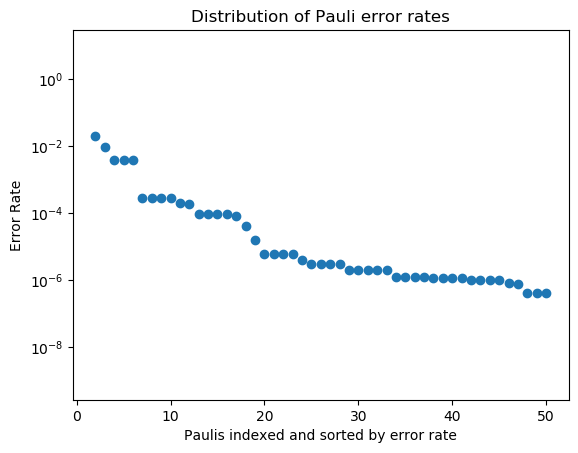

4096-element Array{Float64,1}:
 1.0
 0.972
 0.984
 0.972
 0.9914
 0.979412
 0.9914048
 0.9634168
 0.9918
 0.979804
 0.9918016
 0.9638056
 0.9992
 ⋮
 0.9493371786
 0.922350435
 0.9337424811
 0.9227557376
 0.9497171414
 0.9227227986
 0.9341194043
 0.9231250615
 0.9411471971
 0.9301642532
 0.9415540196
 0.9145710756

In [7]:
# To demonstrate the peeling decoder we are going to set up a sparse (fake) distribution.
# This is going to be a 4 qubit (so 4^6 = 4096 possible probabilities)
# Because of the protocol - we are assuming SPARSE errors - so most of the qubits
# Will be good, but there will be a few errors for us to find.

dist = zeros(4096)
cl = zeros(6,4)

# Qubit 1
cl[1,2] = 0.01 #y1
cl[1,3] = 0.004 #x1
cl[1,4] = 0 #z1
cl[1,1] = 1-sum(cl[1,:])

# Qubit 2
cl[2,2] = 0.0003
cl[2,3] = 0.0001
cl[2,4]=  0
cl[2,1] = 1-sum(cl[2,:])

# Qubit 3
cl[3,2]  = 0.0002
cl[3,3] = 0.0001
cl[3,4] = 0.0003
cl[3,1] = 1-sum(cl[3,:])

# Qubit 4
cl[4,2] = 1e-4
cl[4,3] = 3e-4
cl[4,4] = 0
cl[4,1] = 1-sum(cl[4,:])


# Qubit 5
cl[5,2] = 0.004 
cl[5,3] = 0.02 
cl[5,4] = 0 #z1
cl[5,1] = 1-sum(cl[5,:])


# Qubit 6
cl[6,2] = 1e-4
cl[6,3] = 3e-4
cl[6,4] = 0
cl[6,1] = 1-sum(cl[6,:])




for q1 in 1:4
    for q2 in 1:4
        for q3 in 1:4
            for q4 in 1:4
                for q5 in 1:4
                    for q6 in 1:4
                        dist[(q6-1)*4^5+(q5-1)*4^4+(q4-1)*4^3+(q3-1)*4^2+(q2-1)*4+q1] = cl[1,q1]*cl[2,q2]*cl[3,q3]*cl[4,q4]*cl[5,q5]*cl[6,q6]
                    end
                end
            end
        end
    end
end

dist[3*4^4+2*16+3*4+3+1]= 0.004 # <----- Add an unexpected IZIXZZ error!
dist[1] = 0
dist[1] = 1-sum(dist)
for i in [1e-4,1e-5,1e-6,1e-7]
    print("Number greater than $i = $(count([x>i for x in dist]))\n")
end

print("\nThe Paulis errors we might hope to recover with this protocol:\n")
for (ix,i) in enumerate(dist)
    if i > 0.0001
        print("$(string(ix,pad=3)) $(probabilityLabels(ix-1,qubits=6)) $i\n")
    end
end
title("Distribution of Pauli error rates")
yscale("log")
ylabel("Error Rate")
xlabel("Paulis indexed and sorted by error rate")
scatter(2:50,reverse(sort(dist))[2:50])

print("\n\nThe actual oracle i.e. the eigenvalues of the Pauli channel we are going to use.\n\n")
actualOracle = round.(ifwht_natural(dist),digits=10)

In [8]:
# So we can use our actual oracle to simulate an experiment, we can include some so we will
# Rather than simulate a whole lot of Pauli circuits, which would serve to diagonlise the noise
# I am going to take the simpler state of assuming we have a Pauli channel - the SPAM will
# Therefore just get added on to the end.

# Here I am just assuming a suitable 6 qubit, independent random noise channel for SPAM
rm = foldl(⊗,[randomFidelityNoise() for _ in 1:6])
print("Our random SPAM channel has fidelity $(fidelity(rm)) and unitarity $(unitarity(rm))\n")


Our random SPAM channel has fidelity 0.8543889551204521 and unitarity 0.7634250194208223


In [9]:
# Our noise channel is a Pauli channel, so just diagonalise our eigenvalue vector

using LinearAlgebra
noise = diagm(0=>actualOracle);

In [10]:
# So we have everything we need, we have SPAM channels and the 'diagonal' channel we would get if we 
# averaged over Paulis.

# So Let's get started!

Remember the point here is that the eigenvalues are dense, the pauli error rates are sparse. However, we can't sample the Pauli error rates in a SPAM (state preperation and measurement) error free way. We CAN however sample the eigenvalues in a SPAM free way. We wan't to sparsely sample the dense eigenvalues in order to reconstruct the sparse error probabilities.

This shows how to do this.



# Choose our sub-sampling matrices

One of the main ideas behind the papers is that we can use the protocols in [Efficient learning of quantum channels](https://arxiv.org/abs/1907.12976) and [Efficient learning of quantum noise](https://arxiv.org/abs/1907.13022) to learn the eigenvalues of an entire stabiliser group ($2^n$) entries at once to arbitrary precision. Whilst it might be quite difficult to learn the eigenvalues of an arbitrary group as this will require an arbitrary $n-$qubit Clifford gate (which can be a lot of primitive gates!) even today's noisy devices can quite easily create a 2-local Stabiliser group over $n-$ qubits. 



Finally we are simulating the recovery in a 6 qubit system. That means our bitstrings are 12 bits long. 

Our experiments will need two sub-sampling groups. The first subsampling group will be two of our potential MuBs (set out below) (selected randomly). The second subsampling group will have single MUBs (potentialSingles below) on the first and fourth qubit, and a potential (two qubit) MuB on qubits 2 and 3.

This maximises the seperation of Paulis using local stabiliser (two qubit) groups.

In [11]:
potentialSingles = [
                    [[0,0],[0,1]], # IX
                    [[0,0],[1,0]], # IY
                    [[0,0],[1,1]], # IZ
                    ]


all2QlMuBs =  [  [[0,0,0,0],[1,1,0,1],[1,0,1,1],[0,1,1,0]], #II ZX YZ XY
                 [[0,0,0,0],[1,1,1,0],[0,1,1,1],[1,0,0,1]], #II ZY XZ YX
                 [[0,0,0,0],[0,0,0,1],[0,1,0,0],[0,1,0,1]], #II IX XI XX
                 [[0,0,0,0],[0,0,1,0],[1,0,0,0],[1,0,1,0]], #II IY YI YY
                 [[0,0,0,0],[0,0,1,1],[1,1,0,0],[1,1,1,1]]] #II IZ ZI ZZ

# We only want to choose the first two types for the initial runs
potentialMuBs = [all2QlMuBs[1],all2QlMuBs[2]]






2-element Array{Array{Array{Int64,1},1},1}:
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]

In [12]:
paulisAll=[]
mappings=[]
experiments = []

# For this example I am just going to choose the second type of MUB.
# For six qubits we need three "potentialMuB"

for i = 1:1
     push!(mappings,Dict())
     choose = rand(1:2,3)
     push!(experiments,vcat([(2,choose[1])],[(2,choose[2])],[(2,choose[3])]))
     push!(paulisAll,vcat([potentialMuBs[x] for x in choose]))
end


# For the next subsample group, choose a single, two doubles and a single.
for i = 1:1
         push!(mappings,Dict())
         chooseS = rand(1:3,2)
         choose = rand(1:2,2)
         push!(experiments,vcat([(1,chooseS[1])],[(2,choose[1])],[(2,choose[2])],[(1,chooseS[2])]))
         push!(paulisAll,vcat([potentialSingles[chooseS[1]]],[potentialMuBs[x] for x in choose],[potentialSingles[chooseS[2]]]))
end


# Create the 'bit' offsets
# This is used to work out the Pauli we isolate in a single bin. Here we have 2*(n=2), 4 bits per Pauli
ds = vcat(
    [[0 for _ = 1:12]],
    [map(x->parse(Int,x),collect(reverse(string(i,base=2,pad=12)))) for i in [2^b for b=0:11]]);
# e.g.
print("For the offsets we are using the simplest method for Pauli identification eg:\n")
for (ix,i) in enumerate(ds)
    print("Offset $(ix-1): $i\n")
end

print("\n\nWe have selected two sub-sampling groups. \n\nThe first is two randomly selected 'two quibt' mubs on  the qubits:\n")
print("Qubits 1&2: $(paulisAll[1][1])\n")
print("Qubits 3&4: $(paulisAll[1][2])\n")
print("Qubits 5&6: $(paulisAll[1][3])\n\n")

print("\n\nThe second, we want to offset by 1 qubit, so we have single qubit mubs on qubit 1, a two qubit mub on 2&3 and 4&5 and then we need a single qubit mub on qubit 6.\n")
print("Qubit 1   : $(paulisAll[2][1])\n")
print("Qubits 2&3: $(paulisAll[2][2])\n")
print("Qubits 2&3: $(paulisAll[2][3])\n")
print("Qubit 4.  : $(paulisAll[2][4])\n")
    


For the offsets we are using the simplest method for Pauli identification eg:
Offset 0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Offset 1: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Offset 2: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Offset 3: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Offset 4: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Offset 5: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Offset 6: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Offset 7: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Offset 8: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Offset 9: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Offset 10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Offset 11: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Offset 12: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


We have selected two sub-sampling groups. 

The first is two randomly selected 'two quibt' mubs on  the qubits:
Qubits 1&2: [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]
Qubits 3&4: [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]
Qubits 5&6: [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [

In [13]:
# Here there are two sets of experiments
# The tuple for each qubit, is the (number, experiment type), 
# the numbers for each will add up to 4 (since we have 4 qubits)
experiments

2-element Array{Any,1}:
 [(2, 2), (2, 2), (2, 2)]
 [(1, 3), (2, 2), (2, 1), (1, 2)]

# The Experiments

## So what are these experiments?


Let's pull in the figure from the paper which shows all the experimental designs:

![diagram showing designs](./figures/PhaseOffset.pdf)

Okay that's a bit busy, lets break it down.

Step 1 was to choose one MUB from the set for each pair of qubits, well that is what we did in PaulisAll, lets look at the first element of that

In [14]:
paulisAll[1]

3-element Array{Array{Array{Int64,1},1},1}:
 [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]
 [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]
 [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]

So because it was randomly chosen, you will have to look at that and convince yourself that indeed that each of the two elements shown above are one of these four sets of MuBs.

So the first experiment (the top row of (2)) is just an experiment to extract those eigenvalues.

How do we do that?

Well we have the circuits we need in the appendix of the paper - they look like this:

![circuits](./figures/circuits.png)

Where what we are going to need on each two qubit pair is either (a) or (c), depending on the MUB randomly selected

## Setting up the circuits

For the two qubit expermeints, circuit 1 is (a) above and circuit (2) is (c) above.

Effectively we take an input state in the computational basis, apply these circuits, do a Pauli twirl of varing gates, reverse the circuit and measure in the computational basis.

To simulate this I am just going to set up the circuits as a superoperator. The way rb Pauli twirling works, the noise will be subsumed into the SPAM error - which we will then fit out, but I am getting ahead of myself.

Let's create the superoperator that does (a) and (c) on two qubits:


---
**For a more detailed explanation of what I am doing in the next cell, look at the Hadamard Basics and Observations workbook**

---

In [15]:
using Juqst
# Set up the relevant gates
cnot21 = [1 0;0 1]⊗[1 0;0 0]+ [0 1;1 0]⊗[0 0;0 1]
superCnot21 = makeSuper(cnot21)
superPI = makeSuper([1 0;0 im]⊗[1 0;0 1])
superIP = makeSuper([1 0;0 1]⊗[1 0;0 im])
superHH = makeSuper((1/sqrt(2)*[1 1;1 -1])⊗(1/sqrt(2)*[1 1;1 -1]));
superH = makeSuper((1/sqrt(2)*[1 1;1 -1]))
superP = makeSuper([1 0;0 im])
# The two qubit experiment are (a) and (b) above
# Recall circuits are left to right, matrices right to left
circuit2q = [superCnot21*superPI*superCnot21*superIP*superHH,
             superCnot21*superPI*superCnot21*superPI*superHH]
# The single qubit ones are Paulis, X,Y,Z
circuit1q = [superH,superP*superH,makeSuper([1 0;0 1])];

So the first experiment is as shown in the above diagram ... this bit:

![experiment](./figures/experiment.png)

where our C's (left hand side of that diagram - which I have just noticed is (irritatingly) right to left (you can tell from the |0> on the right). Each of the circuits 2q calculated above represents one of our two choices of Mubs, we would then twirl with Paulis, average over lots of different twirls (to diagonalise it) and then reverse out and measure.

I am NOT going to simulate the Pauli twirl, but rather I am just going to use the (already) diagonal noise matrix we calculated earlier. The noisy circuits2q and state and measurement errors will be simulated by using the measurement (SPAM) noise matrix formed earlier. 

(I probably will do the whole thing in a qiskit simulation)


In [16]:
# So the circuits we want are shown here
experiments[1]

3-element Array{Tuple{Int64,Int64},1}:
 (2, 2)
 (2, 2)
 (2, 2)

In [17]:
function generateGates(experiment,circuits)
    # We expect the gates as a tuple, i.e. (a,b) where a is number of qubits and b is the experiment number
    # circuits is a an array of size upto number of qubits, so circuits[a][b] returns an "a" qubit experiment
    # we can then use foldl to kron up the circuits
    return foldl(⊗, [circuits[x[1]][x[2]] for x in reverse(experiment)])
end

generateGates (generic function with 1 method)

In [18]:
# Simplify the code here, we know its two qubits:
# Note the order of the \kron - obviously with an experiment you just set up the actual experiment!

# You can think of generateGates, doing the equivalent of the following
#initialGates = circuit2q[experiments[1][3][2]]⊗circuit2q[experiments[1][2][2]]⊗circuit2q[experiments[1][1][2]]
initialGates = generateGates(experiments[1],[circuit1q,circuit2q])

reverseGates = transpose(initialGates); # yay superoperators.

In [19]:
# So there is a bit of delay here, mainly its the genZs which isn't the most efficient, but we only do it once.

# We can generate the computational basis measurment vectors (again see Hadamard Basics and Observations for details)
zs = Juqst.genZs(6);
start = zs[1]; #computational basis all 0 state

# Faking (simulating) the experiment

In theory we could put this in qiskit or cirq or something - but here I want to simulate a very
specific noise channel to show we can recover it, and these simulators only allow more general noise
(at the time of writing this).

So the basic concept is: 

- we start with the computational basis vector, 
- we apply our SPAM
- we apply our basis change circuit (initial Gates)
- we apply our diagonal noise $m$ times (this is the noise we want to measure - see below for choice of $m$)
- we undo our basis change
- we find our final probability vector (for observed errors in this basis) (basically each of the measurment arrays we generates - the zs)
- then we face a whole lot of random dice rolls to build up some limited shot statistics.

Finally repeat all the above for different values of $m$. Here we are just going to use m = 1,3,5,8,10,15,20,40,60,80


In [20]:
experiment1_allProbs = []
# These will depend on your system
lengths =  [1,3,5,8,10,15,20,40,60,80]
@showprogress for m in lengths
    wholeCircuit = reverseGates*noise^m*initialGates*rm*start./64 # ./64 = Normalise the measurement/state vectors
    probs = [z'*wholeCircuit for z in zs]
    push!(experiment1_allProbs,probs)
end

# SO NOTE that although there are 4096 eigenvalues, we can only measure 64 of them at a time, 
# so the probability matrices are only 64 long.

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


In [21]:
# Quick Sanity check that all of our probabilityvectors sum to 1
for (ix,i) in enumerate(experiment1_allProbs)
    print("M=$(lengths[ix]) sum = $(round(sum(i),digits=9))\n")
end

M=1 sum = 1.0
M=3 sum = 1.0
M=5 sum = 1.0
M=8 sum = 1.0
M=10 sum = 1.0
M=15 sum = 1.0
M=20 sum = 1.0
M=40 sum = 1.0
M=60 sum = 1.0
M=80 sum = 1.0


In [22]:
# So the final step, now that we have the probability matrix for that experiment, is to simulate limited shot statistics.

# So if we imagined doing 100 sequences, of 200 measurements per seq thats 20,000 shots.
const shotsToDo = 20000

# Quick helper function
function shotSimulator(size,shots,cumulativeMatrix)
    toRet = []
    for todo = 1:length(cumulativeMatrix)
        counted = zeros(size)
        rolls = rand(shots)
        for i in rolls
            #using the fact that the cululativeMatrix is (effectively) sorted.
            counted[searchsortedfirst(cumulativeMatrix[todo],i,)] +=1
        end
        push!(toRet,counted./shots)
    end
    return toRet
end

# We need culmlative probability matrixes
cumMatrix = map(cumsum,experiment1_allProbs)
experiment1_observed = shotSimulator(64,shotsToDo,cumMatrix);

### The next step is to recreate the eigenvalues that we have 'measured' in the experiment. 

This is just following the protocol in https://arxiv.org/abs/1907.13022, Efficient Learning of Quantum Noise
(and https://arxiv.org/abs/1907.12976 Efficient Estimation of Pauli Channels)

###  We want to Hadamard transform the observed Probabilities 

if we do that we will see for each eigenvalue (element in the matrix) an exponential decay curve - lets look

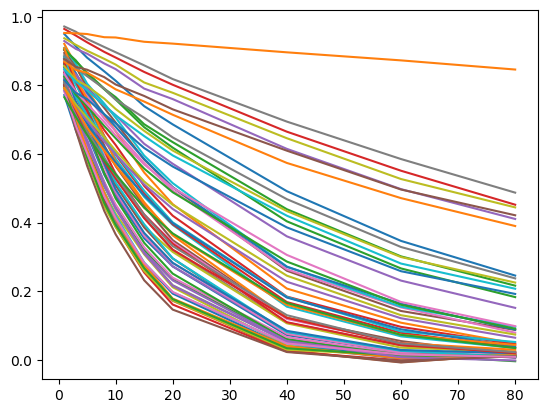

In [23]:
experiment1_SpamyEigenvalues = map(ifwht_natural,experiment1_observed);
# Dont bother with the first element as its all 1.
for x = 2:64
    toPlot = [d[x] for d in experiment1_SpamyEigenvalues]
    plot(lengths,toPlot)
end


## So fit and extract

What we want to do is fit them to and exponential decay curve and extract the decay factor. Juqst has the code for this, and you are welcome to look at the documentation and example notebooks for that!
            
For those that can't be bothered reading docs! fitTheFidelites returns params that contains both the SPAM component and the fidelity - the second parameter is the number of measurements used in the fit and the last is if any of the fits failed. We just want to extract the eigenvalues:

In [24]:
(params,l, failed) = fitTheFidelities(lengths,experiment1_observed)
experiment1_fidelities = vcat(1,[p[2] for p in params]) # We don't fit the first one, it is always 1 for CPTP maps


64-element Array{Float64,1}:
 1.0
 0.9831267474914491
 0.9631152473211371
 0.9796492044884445
 0.9905286607663772
 0.989573437777928
 0.9690609530433411
 0.970258613671411
 0.9913768030247767
 0.9904640978034652
 0.9700359255212225
 0.9709804273158557
 0.9984990896995122
 ⋮
 0.989750939093745
 0.972952574485973
 0.9535144721444119
 0.9691945406143075
 0.9906472391054174
 0.9739591159034393
 0.9546310207446883
 0.9703344907252348
 0.9819861032114456
 0.9811123981006128
 0.9606866822295139
 0.9617911138626483

## So what did we actually extract?

Note this bit is kind of fidly - to get everything to match up

Well we extracted certain fidelities!

The four fidelities on the first qubit were:

In [25]:
paulisAll[1][1]

4-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0]
 [1, 1, 1, 0]
 [0, 1, 1, 1]
 [1, 0, 0, 1]

In [26]:
paulisAll[1][2]

4-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0]
 [1, 1, 1, 0]
 [0, 1, 1, 1]
 [1, 0, 0, 1]

In [27]:
#Turn those into a number...
fidelitiesExtracted = []
function binaryArrayToNumber(x)
    return foldl((y1,y2)->y1<<1+y2,x)
end
for x0 in paulisAll[1][3]
    p56 = binaryArrayToNumber(x0)
    for x1 in paulisAll[1][2]
        p34 = binaryArrayToNumber(x1)
        for x2 in paulisAll[1][1]
            p12= binaryArrayToNumber(x2)
            push!(fidelitiesExtracted,p56*4^4+p34*16+p12+1) # + 1 cause we index of 1 in Julia
        end
    end
end


In [28]:
fidelitiesExtracted

64-element Array{Any,1}:
    1
   15
    8
   10
  225
  239
  232
  234
  113
  127
  120
  122
  145
    ⋮
 2529
 2543
 2536
 2538
 2417
 2431
 2424
 2426
 2449
 2463
 2456
 2458

In [29]:
xx = ifwht_natural([z'*reverseGates*noise*initialGates*start for z in zs]/64)
for p in xx
    print("$p : $(findall(x->isapprox(x,p),actualOracle))\n")
end


1.0000000000000002 : [1]
0.9832064000000004 : [15, 195, 269, 449, 3075, 3329]
0.9634168000000002 : [8, 52]
0.9798040000000003 : [10]
0.9904006400000003 : [45, 225, 3105]
0.9896211041000001 : [239, 493, 3119, 3299, 3373, 3553]
0.9698631548000001 : [232, 2256, 3112, 3216]
0.9702369407000003 : [234, 1230, 3114, 3150]
0.9912001200000004 : [69, 113, 137, 1029, 1073, 2057]
0.9904135538000003 : [127, 381, 1087, 1187, 1223, 1267, 1341, 1441, 1477, 1521, 2147, 2251, 2401, 2505, 3143, 3187, 3211, 3397, 3441, 3465]
0.9706397831000002 : [120, 188, 1080, 1132, 2108]
0.9710202744000004 : [122, 1082]
0.9984006000000005 : [145, 2065]
0.9816210645000005 : [159, 413, 2079, 2259, 2333, 2513, 3219, 3473]
0.9618631160000003 : [152, 1244, 2072, 3164]
0.9782369015000004 : [86, 154, 1046, 2074]
0.9512320000000001 : [525, 705, 3585]
0.9507968975000002 : [719, 3599, 3779]
0.9318140799000001 : [576, 676, 712, 756, 2596, 3592, 3636]
0.9318593505000003 : [610, 714, 1570, 3594]
0.9576978427000002 : [749, 3629, 3809

In [30]:
# And (just out of interest we can compare the fidelities we extracted, with the actual values)
for i in 1:64
    print("$(fidelityLabels(fidelitiesExtracted[i]-1,qubits=6)) ($(fidelitiesExtracted[i]-1)):\tEstimate: $(experiment1_fidelities[i]) <-> $(actualOracle[fidelitiesExtracted[i]]) \tPercentage Error: $(round.(abs(actualOracle[fidelitiesExtracted[i]]-experiment1_fidelities[i])/(actualOracle[fidelitiesExtracted[i]])*100,digits=4))%\n")
end


IIIIII (0):	Estimate: 1.0 <-> 1.0 	Percentage Error: 0.0%
IIIIZY (14):	Estimate: 0.9831267474914491 <-> 0.9832064 	Percentage Error: 0.0081%
IIIIXZ (7):	Estimate: 0.9631152473211371 <-> 0.9634168 	Percentage Error: 0.0313%
IIIIYX (9):	Estimate: 0.9796492044884445 <-> 0.979804 	Percentage Error: 0.0158%
IIZYII (224):	Estimate: 0.9905286607663772 <-> 0.99040064 	Percentage Error: 0.0129%
IIZYZY (238):	Estimate: 0.989573437777928 <-> 0.9896211041 	Percentage Error: 0.0048%
IIZYXZ (231):	Estimate: 0.9690609530433411 <-> 0.9698631548 	Percentage Error: 0.0827%
IIZYYX (233):	Estimate: 0.970258613671411 <-> 0.9702369407 	Percentage Error: 0.0022%
IIXZII (112):	Estimate: 0.9913768030247767 <-> 0.99120012 	Percentage Error: 0.0178%
IIXZZY (126):	Estimate: 0.9904640978034652 <-> 0.9904135538 	Percentage Error: 0.0051%
IIXZXZ (119):	Estimate: 0.9700359255212225 <-> 0.9706397831 	Percentage Error: 0.0622%
IIXZYX (121):	Estimate: 0.9709804273158557 <-> 0.9710202744 	Percentage Error: 0.0041%
IIYXII

### Not bad for 20,000 shots.


## Building up our eigenvalue Oracle

So now we can begin to populate our estimating oracle that we will use to run the peeling decoder.

we have 16 values, lets fill them in...

In [31]:
# Lets make it a vector of vectors 
# - why? Well some of the experiments will have duplicate eigenvalue estimates, and we will want
# To end up averaging them.

estimateOracle = [[] for _ in 1:4096]

for i in 1:64
    push!(estimateOracle[fidelitiesExtracted[i]],experiment1_fidelities[i])
end


In [32]:
estimateOracle

4096-element Array{Array{Any,1},1}:
 [1.0]
 []
 []
 []
 []
 []
 []
 [0.9631152473211371]
 []
 [0.9796492044884445]
 []
 []
 []
 ⋮
 []
 []
 []
 []
 []
 []
 []
 []
 []
 []
 []
 []

In [33]:
# So I am going to just do all of the above for each of the 5 (other than the one already done) for each of the qubits
e1_all_additional_fidelities = []
e1_fidelity_extracted = []
# Note we don't actually need to save the actual probabilities - but I am going to use them later
# To demonstrate some different recovery regimes.
e1_all_actualProbabilities = []
e1_gatesUsed = []
@showprogress 1 "QubitPairs" for qubitPairOn = 1:2 # qubit pairs here are 1&2, 3&4 and 5&6
    for experimentType = 1:2
        if experiments[1][qubitPairOn][2] != experimentType
            # Its one we haven't done
            expOnFirstPair  = experiments[1][1][2]
            expOnSecondPair = experiments[1][2][2]
            expOnThirdPair  = experiments[1][3][2]

            
            if qubitPairOn == 1
                expOnFirstPair = experimentType
            elseif qubitPairOn == 2
                expOnSecondPair = experimentType
            else
                expOnThirdPair = experimentType
            end
            initialGates = circuit2q[expOnThirdPair]⊗circuit2q[expOnSecondPair]⊗circuit2q[expOnFirstPair]
            push!(e1_gatesUsed,initialGates)
            reverseGates = transpose(initialGates) # yay superoperators.
            # So at this point we have set up one of the 'new' experiments.
            additionalExperiment = []
            # Get the actual probabilities.
            @showprogress 1 "QGroup: $qubitPairOn Exp: $experimentType" for m in lengths
                wholeCircuit = rm*reverseGates*noise^m*initialGates*start./64 # Normalising our zs
                probs = [z'*wholeCircuit for z in zs]
                push!(additionalExperiment,probs)
            end
            push!(e1_all_actualProbabilities,additionalExperiment)
            # Generate the measurement statistics
            cumMatrix = map(cumsum,additionalExperiment)
            experiment1_additional_observed = shotSimulator(64,shotsToDo,cumMatrix);
            # Fit and extract the fidelities
            (params,l, failed) = fitTheFidelities(lengths,experiment1_additional_observed)
            experiment1_additional_fidelities = vcat(1,[p[2] for p in params])
            push!(e1_all_additional_fidelities,experiment1_additional_fidelities)
            fidelitiesExtracted=[]
            for x0 in all2QlMuBs[expOnThirdPair]
                p56 = binaryArrayToNumber(x0)
                for x1 in all2QlMuBs[expOnSecondPair]
                    p34 = binaryArrayToNumber(x1)
                    for x2 in all2QlMuBs[expOnFirstPair]
                        p12= binaryArrayToNumber(x2)
                        push!(fidelitiesExtracted,p56*4^4+p34*16+p12+1) # + 1 cause we index of 1 in Julia
                    end
                end
            end
            push!(e1_fidelity_extracted,fidelitiesExtracted)
        end
    end
end


QGroup: 1 Exp: 1100%|███████████████████████████████████| Time: 0:01:15
QGroup: 2 Exp: 1100%|███████████████████████████████████| Time: 0:01:14
QubitPairs100%|█████████████████████████████████████████| Time: 0:02:29


In [34]:
#initialGates = generateGates(experiments[1],[circuit1q,circuit2q])
expOnFirstPair  = experiments[1][1][2]
expOnSecondPair = experiments[1][2][2]
expOnThirdPair  = experiments[1][3][2]
expOnThirdPair = 4
print(expOnFirstPair,expOnSecondPair,expOnThirdPair)
            
initialGates = circuit2q[expOnThirdPair]⊗circuit2q[expOnSecondPair]⊗circuit2q[expOnFirstPair]



reverseGates = transpose(initialGates); # yay superoperators.
experiment1_allProbs = []
# These will depend on your system
lengths =  [1,3,5,8,10,15,20,40,60,80]
@showprogress for m in lengths
    wholeCircuit = reverseGates*noise^m*initialGates*rm*start./64 # ./64 = Normalise the measurement/state vectors
    probs = [z'*wholeCircuit for z in zs]
    push!(experiment1_allProbs,probs)
end


# We need culmlative probability matrixes
cumMatrix = map(cumsum,experiment1_allProbs)
experiment1_observed = shotSimulator(64,shotsToDo,cumMatrix);
(params,l, failed) = fitTheFidelities(lengths,experiment1_observed)
experiment1_fidelities = vcat(1,[p[2] for p in params]) # We don't fit the first one, it is always 1 for CPTP maps

fidelitiesExtracted = []
function binaryArrayToNumber(x)
    return foldl((y1,y2)->y1<<1+y2,x)
end

           for x0 in all2QlMuBs[expOnThirdPair]
                p56 = binaryArrayToNumber(x0)
                for x1 in all2QlMuBs[expOnSecondPair]
                    p34 = binaryArrayToNumber(x1)
                    for x2 in all2QlMuBs[expOnFirstPair]
                        p12= binaryArrayToNumber(x2)
                        push!(fidelitiesExtracted,p56*4^4+p34*16+p12+1) # + 1 cause we index of 1 in Julia
                    end
                end
            end


# for x0 in paulisAll[1][3]
#     p56 = binaryArrayToNumber(x0)
#     for x1 in paulisAll[1][2]
#         p34 = binaryArrayToNumber(x1)
#         for x2 in paulisAll[1][1]
#             p12= binaryArrayToNumber(x2)
#             push!(fidelitiesExtracted,p56*4^4+p34*16+p12+1) # + 1 cause we index of 1 in Julia
#         end
#     end
# end
# And (just out of interest we can compare the fidelities we extracted, with the actual values)
for i in 1:64
    print("$(fidelityLabels(fidelitiesExtracted[i]-1,qubits=6)) ($(fidelitiesExtracted[i]-1)):\tEstimate: $(experiment1_fidelities[i]) <-> $(actualOracle[fidelitiesExtracted[i]]) \tPercentage Error: $(round.(abs(actualOracle[fidelitiesExtracted[i]]-experiment1_fidelities[i])/(actualOracle[fidelitiesExtracted[i]])*100,digits=4))%\n")
end



224

BoundsError: BoundsError: attempt to access 2-element Array{Array{Float64,2},1} at index [4]

### So now we need to put into the oracle the offsets for this experiment we will need.

This is step 2 in the diagram from the paper (a long way back up there $\uparrow$.

Basically for each pair of qubits, we have to cycle through four of the two qubit mubs (there are five but we have done one already). That means we have another 8 experiments, i.e. 2n where n is the number of qubits. For each sub-sampling group we need to do 2n+1 experiments. Let's create the initial and reverse gates for each of the 3 Mubs we haven't already got ([II,IX,XI,XX], [II,IY,YI,YY], [II,IZ,ZI,ZZ]])

In [35]:
# We already had the first bit, repeating just to make the cell self-contained.
circuit2q = [superCnot21*superPI*superCnot21*superIP*superHH,
             superCnot21*superPI*superCnot21*superPI*superHH]

push!(circuit2q,superHH) # The XX one
push!(circuit2q,superIP*superPI*superHH) # the YY one
push!(circuit2q,makeSuper([1 0;0 1]⊗[1 0;0 1])) # The ZZ one i.e. nothing.


5-element Array{Array{Float64,2},1}:
 [1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]

In [36]:
# So I am going to just do all of the above for each of the 5 (other than the one already done) for each of the qubits
e1_all_additional_fidelities = []
e1_fidelity_extracted = []
# Note we don't actually need to save the actual probabilities - but I am going to use them later
# To demonstrate some different recovery regimes.
e1_all_actualProbabilities = []
@showprogress 1 "QubitPairs" for qubitPairOn = 1:3 # qubit pairs here are 1&2, 3&4 and 5&6
    for experimentType = 1:5
        if experiments[1][qubitPairOn][2] != experimentType
            # Its one we haven't done
            expOnFirstPair  = experiments[1][1][2]
            expOnSecondPair = experiments[1][2][2]
            expOnThirdPair  = experiments[1][3][2]

            
            if qubitPairOn == 1
                expOnFirstPair = experimentType
            elseif qubitPairOn == 2
                expOnSecondPair = experimentType
            else
                expOnThirdPair = experimentType
            end
            initialGates = circuit2q[expOnThirdPair]⊗circuit2q[expOnSecondPair]⊗circuit2q[expOnFirstPair]

            reverseGates = transpose(initialGates) # yay superoperators.
            # So at this point we have set up one of the 'new' experiments.
            additionalExperiment = []
            # Get the actual probabilities.
            @showprogress 1 "QGroup: $qubitPairOn Exp: $experimentType" for m in lengths
                wholeCircuit = reverseGates*noise^m*initialGates*rm*start./64 # Normalising our zs
                probs = [z'*wholeCircuit for z in zs]
                push!(additionalExperiment,probs)
            end
            push!(e1_all_actualProbabilities,additionalExperiment)
            # Generate the measurement statistics
            cumMatrix = map(cumsum,additionalExperiment)
            experiment1_additional_observed = shotSimulator(64,shotsToDo,cumMatrix);
            # Fit and extract the fidelities
            (params,l, failed) = fitTheFidelities(lengths,experiment1_additional_observed)
            experiment1_additional_fidelities = vcat(1,[p[2] for p in params])
            push!(e1_all_additional_fidelities,experiment1_additional_fidelities)
            fidelitiesExtracted=[]
            for x0 in all2QlMuBs[expOnThirdPair]
                p56 = binaryArrayToNumber(x0)
                for x1 in all2QlMuBs[expOnSecondPair]
                    p34 = binaryArrayToNumber(x1)
                    for x2 in all2QlMuBs[expOnFirstPair]
                        p12= binaryArrayToNumber(x2)
                        push!(fidelitiesExtracted,p56*4^4+p34*16+p12+1) # + 1 cause we index of 1 in Julia
                    end
                end
            end
            push!(e1_fidelity_extracted,fidelitiesExtracted)
        end
    end
end


QGroup: 1 Exp: 1100%|███████████████████████████████████| Time: 0:01:16
QGroup: 1 Exp: 3100%|███████████████████████████████████| Time: 0:01:15
QGroup: 1 Exp: 4100%|███████████████████████████████████| Time: 0:01:13
QGroup: 1 Exp: 5100%|███████████████████████████████████| Time: 0:01:13
QGroup: 2 Exp: 1100%|███████████████████████████████████| Time: 0:01:16
QGroup: 2 Exp: 3100%|███████████████████████████████████| Time: 0:01:15
QGroup: 2 Exp: 4100%|███████████████████████████████████| Time: 0:01:13
QGroup: 2 Exp: 5100%|███████████████████████████████████| Time: 0:01:13
QGroup: 3 Exp: 1100%|███████████████████████████████████| Time: 0:01:18
QGroup: 3 Exp: 3100%|███████████████████████████████████| Time: 0:01:14
QGroup: 3 Exp: 4100%|███████████████████████████████████| Time: 0:01:13
QGroup: 3 Exp: 5100%|███████████████████████████████████| Time: 0:01:24
QubitPairs100%|█████████████████████████████████████████| Time: 0:15:08


In [37]:
# So for example, if we look at some of these additional 12 experiments, we see
# The following - look at the changing eigevalues we sample (left hand side).
# E.g. exerimpent 12 as qubits 5&6 with the the II IZ ZI ZZ stabiliser.

toExtract = 12

# And (just out of interest we can compare the fidelities we extracted, with the actual values)
for i in 1:64
    print("$(fidelityLabels(e1_fidelity_extracted[toExtract][i]-1,qubits=6)) ",
          "($(e1_fidelity_extracted[toExtract][i])): ",
          "\tEstimate: $(round(e1_all_additional_fidelities[toExtract][i],digits=5))",
          " <-> $(round(actualOracle[e1_fidelity_extracted[toExtract][i]],digits=5)) ",
          "\tPercentage Error: $(round.(abs(actualOracle[e1_fidelity_extracted[toExtract][i]]-e1_all_additional_fidelities[toExtract][i])/(actualOracle[e1_fidelity_extracted[toExtract][i]])*100,digits=4))%\n")
    
end

IIIIII (1): 	Estimate: 1.0 <-> 1.0 	Percentage Error: 0.0%
IIIIZY (15): 	Estimate: 0.98347 <-> 0.98321 	Percentage Error: 0.0272%
IIIIXZ (8): 	Estimate: 0.96332 <-> 0.96342 	Percentage Error: 0.01%
IIIIYX (10): 	Estimate: 0.98032 <-> 0.9798 	Percentage Error: 0.0526%
IIZYII (225): 	Estimate: 0.99051 <-> 0.9904 	Percentage Error: 0.0111%
IIZYZY (239): 	Estimate: 0.98978 <-> 0.98962 	Percentage Error: 0.016%
IIZYXZ (232): 	Estimate: 0.97028 <-> 0.96986 	Percentage Error: 0.0431%
IIZYYX (234): 	Estimate: 0.97089 <-> 0.97024 	Percentage Error: 0.0675%
IIXZII (113): 	Estimate: 0.99131 <-> 0.9912 	Percentage Error: 0.0113%
IIXZZY (127): 	Estimate: 0.99058 <-> 0.99041 	Percentage Error: 0.0166%
IIXZXZ (120): 	Estimate: 0.97095 <-> 0.97064 	Percentage Error: 0.0316%
IIXZYX (122): 	Estimate: 0.97157 <-> 0.97102 	Percentage Error: 0.0571%
IIYXII (145): 	Estimate: 0.99845 <-> 0.9984 	Percentage Error: 0.0047%
IIYXZY (159): 	Estimate: 0.98197 <-> 0.98162 	Percentage Error: 0.0356%
IIYXXZ (152): 	E

In [38]:
# So we just need to fill in the oracle

for (expNo,x) in enumerate(e1_fidelity_extracted)
    for (fidelityIndex,fidelity)  in enumerate(x)
        push!(estimateOracle[fidelity],e1_all_additional_fidelities[expNo][fidelityIndex])
    end
end

In [39]:
# our oracle so far
for i in 1:4096
    if estimateOracle[i]!=[]
        print("$(string(i,pad=3)) $(round.(actualOracle[i],digits=5)) \t$(round.(estimateOracle[i],digits=5))\n")
    end
end

001 1.0 	[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
002 0.972 	[0.972]
003 0.984 	[0.98365]
004 0.972 	[0.97219]
005 0.9914 	[0.99147]
006 0.97941 	[0.97922]
007 0.9914 	[0.99137]
008 0.96342 	[0.96312, 0.96293, 0.96256, 0.9632, 0.96438, 0.96309, 0.96304, 0.96267, 0.96332]
009 0.9918 	[0.99165]
010 0.9798 	[0.97965, 0.97953, 0.97955, 0.98015, 0.97955, 0.97951, 0.97966, 0.97976, 0.98032]
011 0.9918 	[0.99174]
012 0.96381 	[0.96422]
013 0.9992 	[0.99917]
014 0.97122 	[0.97163]
015 0.98321 	[0.98313, 0.98329, 0.98304, 0.98305, 0.9832, 0.98303, 0.98299, 0.98286, 0.98347]
016 0.97122 	[0.97146]
017 0.999 	[0.99903]
024 0.96245 	[0.96144]
026 0.97882 	[0.97856]
031 0.98222 	[0.98194]
033 0.9912 	[0.99114]
040 0.97064 	[0.9707]
042 0.97102 	[0.97108]
047 0.99041 	[0.99028]
049 0.9914 	[0.99156]
056 0.97083 	[0.97118]
058 0.97122 	[0.97141]
063 0.99061 	[0.99045]
065 0.9998 	[0.9998]
072 0.96322 	[0.96241]
074 0.97961 	[0.97934]
079 0.98301 	[0.98288]
081 0.9988 	[0.9988

2427 0.98249 	[0.98223]
2428 0.95468 	[0.95529]
2429 0.98982 	[0.99001]
2430 0.96202 	[0.96179]
2431 0.9739 	[0.97396]
2432 0.9621 	[0.96245]
2433 0.98281 	[0.98269]
2440 0.96249 	[0.9622]
2442 0.9628 	[0.96203]
2447 0.9821 	[0.98238]
2449 0.98182 	[0.98199, 0.98203, 0.98168, 0.98142, 0.98181]
2450 0.97002 	[0.96998]
2451 0.9819 	[0.98181]
2452 0.9541 	[0.9542]
2453 0.98923 	[0.98914]
2454 0.96144 	[0.96122]
2455 0.97331 	[0.97369]
2456 0.96153 	[0.96069]
2457 0.98962 	[0.98931]
2458 0.96183 	[0.96179]
2459 0.9737 	[0.97325]
2460 0.96191 	[0.96215]
2461 0.98103 	[0.98102]
2462 0.96925 	[0.96929]
2463 0.98112 	[0.98111]
2464 0.95333 	[0.95369]
2465 0.99002 	[0.98994]
2472 0.95372 	[0.95267]
2474 0.97002 	[0.96986]
2479 0.97331 	[0.97336]
2481 0.99022 	[0.99017]
2488 0.95391 	[0.95301]
2490 0.97022 	[0.96935]
2495 0.97351 	[0.973]
2497 0.98261 	[0.98272]
2504 0.9623 	[0.963]
2506 0.96261 	[0.96298]
2511 0.9819 	[0.98192]
2513 0.98162 	[0.98126]
2520 0.96133 	[0.96044]
2522 0.96163 	[0.96

In [40]:
e1_fidelity_extracted

12-element Array{Any,1}:
 Any[1, 14, 12, 7, 225, 238, 236, 231, 113, 126  …  2540, 2535, 2417, 2430, 2428, 2423, 2449, 2462, 2460, 2455]
 Any[1, 2, 5, 6, 225, 226, 229, 230, 113, 114  …  2533, 2534, 2417, 2418, 2421, 2422, 2449, 2450, 2453, 2454]
 Any[1, 3, 9, 11, 225, 227, 233, 235, 113, 115  …  2537, 2539, 2417, 2419, 2425, 2427, 2449, 2451, 2457, 2459]
 Any[1, 4, 13, 16, 225, 228, 237, 240, 113, 116  …  2541, 2544, 2417, 2420, 2429, 2432, 2449, 2452, 2461, 2464]
 Any[1, 15, 8, 10, 209, 223, 216, 218, 177, 191  …  2520, 2522, 2481, 2495, 2488, 2490, 2401, 2415, 2408, 2410]
 Any[1, 15, 8, 10, 17, 31, 24, 26, 65, 79  …  2328, 2330, 2369, 2383, 2376, 2378, 2385, 2399, 2392, 2394]
 Any[1, 15, 8, 10, 33, 47, 40, 42, 129, 143  …  2344, 2346, 2433, 2447, 2440, 2442, 2465, 2479, 2472, 2474]
 Any[1, 15, 8, 10, 49, 63, 56, 58, 193, 207  …  2360, 2362, 2497, 2511, 2504, 2506, 2545, 2559, 2552, 2554]
 Any[1, 15, 8, 10, 225, 239, 232, 234, 113, 127  …  1768, 1770, 1649, 1663, 1656, 1658, 1681, 16

## Okay that is all of exeriment 1 and its offsets done. 

That leaves experiment 2 (we need two subsampling groups for the peeling decoder)

Recall experiment 2 looks like this:

# Experiment 2

In [41]:
experiments[2]

4-element Array{Tuple{Int64,Int64},1}:
 (1, 3)
 (2, 2)
 (2, 1)
 (1, 2)

In [42]:
# So q1, has single qubit mub, q2&3 4&5 have a double mub experiment type 2 and q6 has a single mub, so lets set that up:

initialGates = generateGates(experiments[2],[circuit1q,circuit2q])
reverseGates = transpose(initialGates) 
# So at this point we have set up one of the 'new' experiments.

experiment2 = []
# Get the actual probabilities.
@showprogress 1 "Lengths: " for m in lengths
    wholeCircuit = reverseGates*noise^m*initialGates*rm*start./64 # Normalising our zs
    probs = [z'*wholeCircuit for z in zs]
    push!(experiment2,probs)
end
            


Lengths: 100%|██████████████████████████████████████████| Time: 0:01:37


In [43]:
# Generate shot limited stats

cumMatrix = map(cumsum,experiment2)
experiment2_observed = shotSimulator(64,shotsToDo,cumMatrix);
# Fit and extract the fidelities
(params,l, failed) = fitTheFidelities(lengths,experiment2_observed)
experiment2_fidelities = vcat(1,[p[2] for p in params])

64-element Array{Float64,1}:
 1.0
 0.9723314962199999
 0.9991163399082574
 0.9714274556162901
 0.9981781030486253
 0.9702159183854494
 0.9985829861749448
 0.970613736682594
 0.9520459866687843
 0.9255472621981686
 0.9507978727380862
 0.9241999281621519
 0.9501636977919786
 ⋮
 0.9492250525395916
 0.9229033298673885
 0.9491899060623097
 0.9230270582060898
 0.9831345399213267
 0.95491567911988
 0.9822532984333032
 0.9538797833999519
 0.9812872417469337
 0.9525232297206297
 0.9816024796344941
 0.9525629548423751

In [44]:
xx = ifwht_natural([z'*reverseGates*noise*initialGates*start for z in zs]/64)
for p in xx
    print("$p : $(findall(x->isapprox(x,p),actualOracle))\n")
end


1.0 : [1]
0.972 : [2, 4]
0.99920012 : [57, 1153, 2113]
0.9712225166 : [60, 1156, 2116]
0.9982008 : [29, 209, 3089]
0.9702511776 : [32, 212, 3092]
0.9986004800000001 : [37, 141, 2061, 2241, 3201]
0.9706396666000001 : [40, 144, 2064, 2244, 3204]
0.9518096 : [833, 1793]
0.9251589311999999 : [836, 1796]
0.9510482664999999 : [889, 1849]
0.9244189151 : [892, 1852]
0.9500971041999999 : [861, 1821, 2001, 3921]
0.9234943852999999 : [864, 1824, 2004, 3924]
0.9504775233999999 : [869, 937, 1017, 1829, 1933, 2857, 2893, 3897]
0.9238641528 : [872, 940, 1020, 1832, 1936, 2860, 2896, 3900]
0.9512320000000001 : [525, 705, 3585]
0.9243735040000002 : [528, 708, 3588]
0.9504647295 : [613, 681, 761, 1573, 1677, 2601, 2637, 3641]
0.9236277171000002 : [616, 684, 764, 1576, 1680, 2604, 2640, 3644]
0.9495061498 : [733, 3613, 3793]
0.9226959776000001 : [736, 3616, 3796]
0.9498895356000002 : [741, 2765, 3621, 3725]
0.9230686286000004 : [744, 2768, 3624, 3728]
0.9834048 : [131, 385, 2051, 2305]
0.9556454656000001

In [45]:
fidelitiesExtracted = []
for x1b in potentialSingles[experiments[2][4][2]] # Experiment 2, qubit division 3 (q1, q2&3, q4) the second part = exp number
    p6 = binaryArrayToNumber(x1b)
    for x2b in all2QlMuBs[experiments[2][3][2]]
        p45 = binaryArrayToNumber(x2b)
        for x2a in all2QlMuBs[experiments[2][2][2]]
            p23 = binaryArrayToNumber(x2a)
            for x1a in potentialSingles[experiments[2][1][2]]
                p1 = binaryArrayToNumber(x1a)
                push!(fidelitiesExtracted,p6*4^5+p45*4^3+p23*4^1+p1+1) # + 1 cause we index of 1 in Julia
             end
        end
    end
end
map(x->fidelityLabels(x-1,qubits=6),fidelitiesExtracted)

64-element Array{String,1}:
 "IIIIII"
 "IIIIIZ"
 "IIIZYI"
 "IIIZYZ"
 "IIIXZI"
 "IIIXZZ"
 "IIIYXI"
 "IIIYXZ"
 "IZXIII"
 "IZXIIZ"
 "IZXZYI"
 "IZXZYZ"
 "IZXXZI"
 ⋮
 "YYZXZI"
 "YYZXZZ"
 "YYZYXI"
 "YYZYXZ"
 "YXYIII"
 "YXYIIZ"
 "YXYZYI"
 "YXYZYZ"
 "YXYXZI"
 "YXYXZZ"
 "YXYYXI"
 "YXYYXZ"

In [46]:
# And (just out of interest we can compare the fidelities we extracted, with the actual values)
for i in 1:64
    print("$(fidelityLabels(fidelitiesExtracted[i]-1,qubits=6)) ",
        "($(fidelitiesExtracted[i]-1)):\tEstimate: $(experiment2_fidelities[i]) ",
        "<-> $(actualOracle[fidelitiesExtracted[i]]) \t",
        "Percentage Error: $(round.(abs(actualOracle[fidelitiesExtracted[i]]-experiment2_fidelities[i])/(actualOracle[fidelitiesExtracted[i]])*100,digits=4))%\n")
end

IIIIII (0):	Estimate: 1.0 <-> 1.0 	Percentage Error: 0.0%
IIIIIZ (3):	Estimate: 0.9723314962199999 <-> 0.972 	Percentage Error: 0.0341%
IIIZYI (56):	Estimate: 0.9991163399082574 <-> 0.99920012 	Percentage Error: 0.0084%
IIIZYZ (59):	Estimate: 0.9714274556162901 <-> 0.9712225166 	Percentage Error: 0.0211%
IIIXZI (28):	Estimate: 0.9981781030486253 <-> 0.9982008 	Percentage Error: 0.0023%
IIIXZZ (31):	Estimate: 0.9702159183854494 <-> 0.9702511776 	Percentage Error: 0.0036%
IIIYXI (36):	Estimate: 0.9985829861749448 <-> 0.99860048 	Percentage Error: 0.0018%
IIIYXZ (39):	Estimate: 0.970613736682594 <-> 0.9706396666 	Percentage Error: 0.0027%
IZXIII (832):	Estimate: 0.9520459866687843 <-> 0.9518096 	Percentage Error: 0.0248%
IZXIIZ (835):	Estimate: 0.9255472621981686 <-> 0.9251589312 	Percentage Error: 0.042%
IZXZYI (888):	Estimate: 0.9507978727380862 <-> 0.9510482665 	Percentage Error: 0.0263%
IZXZYZ (891):	Estimate: 0.9241999281621519 <-> 0.9244189151 	Percentage Error: 0.0237%
IZXXZI (860)

In [47]:
# Save you the sanity check and I will put these directly into the oracle

for (fidelityIndex,fidelity)  in enumerate(fidelitiesExtracted)
    push!(estimateOracle[fidelity],experiment2_fidelities[fidelityIndex])
end

In [48]:
# our oracle so far
for i in 1:4096
    if estimateOracle[i]!=[]
        print("$(string(i,pad=3)) $(round.(actualOracle[i],digits=5)) \t$(round.(estimateOracle[i],digits=5))\n")
    end
end

001 1.0 	[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
002 0.972 	[0.972]
003 0.984 	[0.98365]
004 0.972 	[0.97219, 0.97233]
005 0.9914 	[0.99147]
006 0.97941 	[0.97922]
007 0.9914 	[0.99137]
008 0.96342 	[0.96312, 0.96293, 0.96256, 0.9632, 0.96438, 0.96309, 0.96304, 0.96267, 0.96332]
009 0.9918 	[0.99165]
010 0.9798 	[0.97965, 0.97953, 0.97955, 0.98015, 0.97955, 0.97951, 0.97966, 0.97976, 0.98032]
011 0.9918 	[0.99174]
012 0.96381 	[0.96422]
013 0.9992 	[0.99917]
014 0.97122 	[0.97163]
015 0.98321 	[0.98313, 0.98329, 0.98304, 0.98305, 0.9832, 0.98303, 0.98299, 0.98286, 0.98347]
016 0.97122 	[0.97146]
017 0.999 	[0.99903]
024 0.96245 	[0.96144]
026 0.97882 	[0.97856]
029 0.9982 	[0.99818]
031 0.98222 	[0.98194]
032 0.97025 	[0.97022]
033 0.9912 	[0.99114]
037 0.9986 	[0.99858]
040 0.97064 	[0.9707, 0.97061]
042 0.97102 	[0.97108]
047 0.99041 	[0.99028]
049 0.9914 	[0.99156]
056 0.97083 	[0.97118]
057 0.9992 	[0.99912]
058 0.97122 	[0.97141]
060 0.97122 	[0.9714

2320 0.95487 	[0.95512]
2321 0.98241 	[0.9822]
2328 0.9621 	[0.96235]
2330 0.96241 	[0.96206]
2335 0.9817 	[0.98162]
2337 0.99061 	[0.99056]
2344 0.9543 	[0.95305]
2346 0.97061 	[0.97049]
2351 0.9739 	[0.97379]
2353 0.99081 	[0.99096]
2360 0.95449 	[0.95503]
2362 0.9708 	[0.97055]
2367 0.9741 	[0.97331]
2369 0.98321 	[0.98308]
2376 0.96287 	[0.96319]
2378 0.96319 	[0.96286]
2383 0.98249 	[0.98258]
2385 0.98222 	[0.982]
2392 0.96191 	[0.96229]
2394 0.96222 	[0.96194]
2399 0.98151 	[0.98148]
2401 0.99041 	[0.99044]
2408 0.9541 	[0.95335]
2410 0.97041 	[0.96991]
2415 0.9737 	[0.97323]
2417 0.99061 	[0.99065, 0.99056, 0.99064, 0.99036, 0.9908]
2418 0.9628 	[0.96282]
2419 0.97469 	[0.97441]
2420 0.96287 	[0.96307]
2421 0.98202 	[0.98194]
2422 0.97022 	[0.96993]
2423 0.9821 	[0.98198]
2424 0.9543 	[0.95463]
2425 0.98241 	[0.98204]
2426 0.97061 	[0.97033]
2427 0.98249 	[0.98223]
2428 0.95468 	[0.95529]
2429 0.98982 	[0.99001]
2430 0.96202 	[0.96179]
2431 0.9739 	[0.97396]
2432 0.9621 	[0.9624

### And super finally we just need to create the offsets to get their fidelities.

For the single qubit Mubs, we need the other 2 mubs, for the two qubit Mubs the other four.


In [49]:

e2_all_additional_fidelities = []
e2_fidelity_extracted = []
# Note here I am hard coding that we have single qubit twirls on 1 and 4.
e_count = 0
e2_all_actualProbabilities = []
@showprogress 1 "Qubits: " for qubitOn in 1:4 # qubits we can be "On" here are 1, 2&3 4&5 and 6
    
    if qubitOn == 2 || qubitOn == 3
        noOfExperiments = 5
    else 
        noOfExperiments = 3 # Only 3 if its a single qubit.
    end
    for experimentType = 1:noOfExperiments
        if experiments[2][qubitOn][2] != experimentType
            # Its one we haven't done
            expOnFirstSet = experiments[2][1][2]
            expOnSecondSet = experiments[2][2][2]
            expOnThirdSet = experiments[2][3][2]
            expOnFourthSet = experiments[2][4][2]


            if qubitOn == 1
                expOnFirstSet = experimentType
            elseif qubitOn == 2
                expOnSecondSet = experimentType
            elseif qubitOn ==3 
                expOnThirdSet = experimentType
            else 
                expOnFourthSet = experimentType
            end
                
            initialGates = circuit1q[expOnFourthSet]⊗circuit2q[expOnThirdSet]⊗circuit2q[expOnSecondSet]⊗circuit1q[expOnFirstSet]

            reverseGates = transpose(initialGates) # yay superoperators.
            # So at this point we have set up one of the 'new' experiments.
            additionalExperiment = []
            # Get the actual probabilities.
            @showprogress 1 "QGroup $qubitOn Exp: $experimentType: " for m in lengths
                wholeCircuit = reverseGates*noise^m*initialGates*rm*start./64 # Normalising our zs
                probs = [z'*wholeCircuit for z in zs]
                push!(additionalExperiment,probs)
            end
            push!(e2_all_actualProbabilities,additionalExperiment)
            
            # Generate the measurement statistics
            cumMatrix = map(cumsum,additionalExperiment)
            experiment2_additional_observed =  shotSimulator(64,shotsToDo,cumMatrix);
            # Fit and extract the fidelities
            (params,l, failed) = fitTheFidelities(lengths,experiment2_additional_observed)
            experiment2_additional_fidelities = vcat(1,[p[2] for p in params])
            push!(e2_all_additional_fidelities,experiment2_additional_fidelities)
            fidelitiesExtracted=[]
            for x1 in potentialSingles[expOnFourthSet] # Experiment 2, qubit division 3 (q1, q2&3, q4&5 q6) the second part = exp number
                p6 = binaryArrayToNumber(x1)
                for x2b in all2QlMuBs[expOnThirdSet]
                    p45 = binaryArrayToNumber(x2b)
                    for x2 in all2QlMuBs[expOnSecondSet]
                        p23 = binaryArrayToNumber(x2)
                        for x3 in potentialSingles[expOnFirstSet]
                            p1 = binaryArrayToNumber(x3)
                            push!(fidelitiesExtracted,p6*4^5+p45*4^3+p23*4+p1+1) # + 1 cause we index of 1 in Julia
                        end
                     end
                end
            end
            push!(e2_fidelity_extracted,fidelitiesExtracted)
        end
    end
end

QGroup 1 Exp: 1: 100%|██████████████████████████████████| Time: 0:01:33
QGroup 1 Exp: 2: 100%|██████████████████████████████████| Time: 0:01:34
QGroup 2 Exp: 1: 100%|██████████████████████████████████| Time: 0:01:35
QGroup 2 Exp: 3: 100%|██████████████████████████████████| Time: 0:01:37
QGroup 2 Exp: 4: 100%|██████████████████████████████████| Time: 0:01:33
QGroup 2 Exp: 5: 100%|██████████████████████████████████| Time: 0:01:39
QGroup 3 Exp: 2: 100%|██████████████████████████████████| Time: 0:01:35
QGroup 3 Exp: 3: 100%|██████████████████████████████████| Time: 0:01:34
QGroup 3 Exp: 4: 100%|██████████████████████████████████| Time: 0:01:35
QGroup 3 Exp: 5: 100%|██████████████████████████████████| Time: 0:01:35
QGroup 4 Exp: 1: 100%|██████████████████████████████████| Time: 0:01:34
QGroup 4 Exp: 3: 100%|██████████████████████████████████| Time: 0:01:35
Qubits: 100%|███████████████████████████████████████████| Time: 0:19:06


In [50]:
e2_all_additional_fidelities[1]

64-element Array{Float64,1}:
 1.0
 0.9720010618845809
 0.9992450374377815
 0.9711014622951993
 0.9981589071811008
 0.9699857548384688
 0.9986535292065203
 0.9704945402235663
 0.9518859784538344
 0.9254873846894776
 0.9509609515720149
 0.9245679185669617
 0.9502400201810287
 ⋮
 0.9491470989913241
 0.9385224148916937
 0.9492826374649183
 0.9386491148472559
 0.9828298070906912
 0.9710418302360359
 0.9818785926176788
 0.9702018833508965
 0.9808549347029974
 0.9693170111351157
 0.9812441752715589
 0.9697264115529066

In [51]:
# So for example, if we look experiment 8 of these additional experiments, we see
toExtract = 8

# And (just out of interest we can compare the fidelities we extracted, with the actual values)
for i in 1:64
    print("$(fidelityLabels(e2_fidelity_extracted[toExtract][i]-1,qubits=6)) ",
          "($(e2_fidelity_extracted[toExtract][i])): ",
          "\tEstimate: $(round(e2_all_additional_fidelities[toExtract][i],digits=5))",
          " <-> $(round(actualOracle[e2_fidelity_extracted[toExtract][i]],digits=5)) ",
          "\tPercentage Error: $(round.(abs(actualOracle[e2_fidelity_extracted[toExtract][i]]-e2_all_additional_fidelities[toExtract][i])/(actualOracle[e2_fidelity_extracted[toExtract][i]])*100,digits=4))%\n")
    
end

IIIIII (1): 	Estimate: 1.0 <-> 1.0 	Percentage Error: 0.0%
IIIIIZ (4): 	Estimate: 0.9721 <-> 0.972 	Percentage Error: 0.0106%
IIIZYI (57): 	Estimate: 0.99922 <-> 0.9992 	Percentage Error: 0.0018%
IIIZYZ (60): 	Estimate: 0.97132 <-> 0.97122 	Percentage Error: 0.0102%
IIIXZI (29): 	Estimate: 0.99815 <-> 0.9982 	Percentage Error: 0.0056%
IIIXZZ (32): 	Estimate: 0.97031 <-> 0.97025 	Percentage Error: 0.0057%
IIIYXI (37): 	Estimate: 0.99853 <-> 0.9986 	Percentage Error: 0.0068%
IIIYXZ (40): 	Estimate: 0.97071 <-> 0.97064 	Percentage Error: 0.0068%
IIXIII (65): 	Estimate: 0.99982 <-> 0.9998 	Percentage Error: 0.002%
IIXIIZ (68): 	Estimate: 0.97169 <-> 0.97181 	Percentage Error: 0.0115%
IIXZYI (121): 	Estimate: 0.99904 <-> 0.999 	Percentage Error: 0.0035%
IIXZYZ (124): 	Estimate: 0.97095 <-> 0.97103 	Percentage Error: 0.0077%
IIXXZI (93): 	Estimate: 0.99798 <-> 0.998 	Percentage Error: 0.0017%
IIXXZZ (96): 	Estimate: 0.96994 <-> 0.97006 	Percentage Error: 0.012%
IIXYXI (101): 	Estimate: 0.998

In [52]:
# Okay load them all up into the oracle

for (expNo,x) in enumerate(e2_fidelity_extracted)
    for (fidelityIndex,fidelity)  in enumerate(x)
        push!(estimateOracle[fidelity],e2_all_additional_fidelities[expNo][fidelityIndex])
    end
end

In [53]:
# our oracle so far
for i in 1:4096
    if estimateOracle[i]!=[]
        print("$(string(i,pad=3)) $(round.(actualOracle[i],digits=5)) \t$(round.(estimateOracle[i],digits=5))\n")
    end
end

001 1.0 	[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
002 0.972 	[0.972, 0.972]
003 0.984 	[0.98365, 0.9839]
004 0.972 	[0.97219, 0.97233, 0.97229, 0.97164, 0.97179, 0.97231, 0.97189, 0.9721, 0.97159, 0.97191, 0.97159, 0.97167]
005 0.9914 	[0.99147, 0.99123]
006 0.97941 	[0.97922]
007 0.9914 	[0.99137]
008 0.96342 	[0.96312, 0.96293, 0.96256, 0.9632, 0.96438, 0.96309, 0.96304, 0.96267, 0.96332, 0.96352]
009 0.9918 	[0.99165, 0.99209]
010 0.9798 	[0.97965, 0.97953, 0.97955, 0.98015, 0.97955, 0.97951, 0.97966, 0.97976, 0.98032]
011 0.9918 	[0.99174]
012 0.96381 	[0.96422, 0.96399]
013 0.9992 	[0.99917, 0.99916]
014 0.97122 	[0.97163]
015 0.98321 	[0.98313, 0.98329, 0.98304, 0.98305, 0.9832, 0.98303, 0.98299, 0.98286, 0.98347]
016 0.97122 	[0.97146, 0.97169]
017 0.999 	[0.99903, 0.99901]
020 0.97103 	[0.97052]
021 0.9904 	[0.9903]
024 0.96245 	[0.96144, 0.96231]
025 0.9908 	[0.99075]
026 0.97882 	[0.9785

889 0.95105 	[0.9508, 0.95096, 0.95102, 0.9508, 0.95139]
890 0.92403 	[0.92381, 0.92457]
891 0.93544 	[0.93508]
892 0.92442 	[0.9242, 0.92429, 0.92472]
893 0.94248 	[0.94277]
895 0.94287 	[0.94346]
896 0.91586 	[0.91587]
897 0.95143 	[0.95104]
900 0.92479 	[0.92392]
913 0.95048 	[0.95066]
920 0.91531 	[0.91462]
922 0.93128 	[0.93144]
925 0.94972 	[0.94902]
927 0.93412 	[0.93418]
928 0.92312 	[0.92186]
933 0.9501 	[0.94958]
936 0.92349 	[0.92286]
953 0.95067 	[0.95026]
956 0.92405 	[0.92374]
961 0.95124 	[0.95101]
964 0.9246 	[0.92344]
989 0.94953 	[0.94954]
992 0.92294 	[0.92181]
993 0.94248 	[0.94213]
997 0.94991 	[0.94965]
1000 0.92331 	[0.92345, 0.92245]
1002 0.92328 	[0.92275]
1007 0.94212 	[0.94303]
1017 0.95048 	[0.95009]
1020 0.92386 	[0.92274]
1025 0.9998 	[0.9998, 0.99981]
1028 0.97181 	[0.97142]
1032 0.96322 	[0.96287]
1034 0.97961 	[0.97946]
1039 0.98301 	[0.98276]
1053 0.998 	[0.998]
1056 0.97006 	[0.96957]
1061 0.9984 	[0.99841]
1064 0.97045 	[0.96986]
1081 0.999 	[0.999]


2457 0.98962 	[0.98931, 0.98961]
2458 0.96183 	[0.96179]
2459 0.9737 	[0.97325]
2460 0.96191 	[0.96215, 0.96196]
2461 0.98103 	[0.98102, 0.98129, 0.98085, 0.981]
2462 0.96925 	[0.96929, 0.96932]
2463 0.98112 	[0.98111, 0.98119]
2464 0.95333 	[0.95369, 0.95252]
2465 0.99002 	[0.98994, 0.99005]
2468 0.9623 	[0.96201]
2469 0.98142 	[0.9816, 0.98124, 0.98152]
2470 0.96963 	[0.96973]
2471 0.98151 	[0.98151]
2472 0.95372 	[0.95267, 0.95256]
2473 0.98182 	[0.98218]
2474 0.97002 	[0.96986]
2476 0.9541 	[0.95435]
2477 0.98923 	[0.98922]
2479 0.97331 	[0.97336]
2480 0.96153 	[0.96165]
2481 0.99022 	[0.99017, 0.99039]
2484 0.96249 	[0.96303]
2485 0.98162 	[0.98134]
2488 0.95391 	[0.95301, 0.95449]
2489 0.98202 	[0.98225, 0.98188, 0.98202]
2490 0.97022 	[0.96935, 0.9702]
2491 0.9821 	[0.98193]
2492 0.9543 	[0.95388]
2493 0.98942 	[0.98952]
2495 0.97351 	[0.973]
2496 0.96172 	[0.96221]
2497 0.98261 	[0.98272, 0.9826]
2500 0.95487 	[0.9547]
2504 0.9623 	[0.963]
2506 0.96261 	[0.96298]
2511 0.9819 	[

3964 0.92368 	[0.92351]
3967 0.94212 	[0.94298]
3985 0.94972 	[0.95014]
3992 0.91457 	[0.91397]
3994 0.93054 	[0.93065]
3999 0.93337 	[0.93381]
4065 0.94172 	[0.94156]
4072 0.92257 	[0.92282]
4074 0.92254 	[0.92187]
4079 0.94137 	[0.94256]


In [54]:
using Statistics
# So we can get an idea of the variance in the oracle (where we have fidelities)
# This is based off 1,000 shots per 'experiment sequence'
for (ix,i) in enumerate(estimateOracle)
    if length(i) > 1 
        print("$ix: $(var(i))\n")
    end
end

1: 0.0
2: 1.0171905423749152e-12
3: 3.14910288763136e-8
4: 8.597381359546434e-8
5: 2.7335405968551232e-8
8: 2.5539299262426695e-7
9: 9.810744259413811e-8
10: 8.585757937980676e-8
12: 2.7374693221766556e-8
13: 1.0013890228497007e-10
15: 3.319078088184638e-8
16: 2.6147006713125354e-8
17: 1.5919641457028167e-10
24: 3.786123103185474e-7
29: 2.9394956733523843e-10
31: 3.536841114239794e-8
32: 5.49838855426111e-8
33: 6.271284069635471e-8
37: 1.3250066724237544e-9
40: 6.514812721650733e-8
49: 3.1929537588268213e-9
56: 1.982568248624735e-9
57: 1.3941946297681945e-9
58: 4.6974575527858454e-8
60: 1.0132489487681191e-7
65: 1.875280454610674e-10
104: 5.5618843674861433e-8
113: 1.8183026423479614e-8
120: 1.308201369177607e-7
121: 3.211537502993726e-9
122: 1.445188838947905e-7
124: 3.6357818201084482e-9
127: 1.175787862912922e-8
129: 2.54890165022972e-10
145: 2.9393865965896504e-9
152: 7.394052626755049e-8
154: 1.1367547079618876e-7
157: 1.936552453672428e-10
159: 5.907075661513566e-8
160: 4.1806766

In [55]:
# Get our oracle single figure
oracleToUse = [length(x) > 0 ? mean(x) : 0 for x in estimateOracle]

4096-element Array{Real,1}:
 1.0
 0.9720003487259231
 0.9837729332182079
 0.9719415990645709
 0.9913507755848848
 0.9792198913325938
 0.9913657852436378
 0.9631818897414561
 0.9918684060540095
 0.9797428924654792
 0.9917411894205117
 0.964104023293646
 0.9991640420318935
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [56]:
# Just out of intereset we can now work out the error in the oracle using this number of shots and our
# fitting algorithm:
print("Actual error in the eigenvalues estimated\n")
avE =[]
for (ix,i) in enumerate(oracleToUse)
    if i !=0
        percentError = round((i-actualOracle[ix])/actualOracle[ix]*100,digits=6)
        push!(avE,percentError)
        print("$(string(ix,pad=4)): $(fidelityLabels(ix-1,qubits=6)): $(round(percentError,digits=3))%\n")
    end
end
print("Mean error = $(round(mean(avE),digits=4))%, std = $(round(std(avE),digits=5))(%)\n")

Actual error in the eigenvalues estimated
0001: IIIIII: 0.0%
0002: IIIIIX: 0.0%
0003: IIIIIY: -0.023%
0004: IIIIIZ: -0.006%
0005: IIIIXI: -0.005%
0006: IIIIXX: -0.02%
0007: IIIIXY: -0.004%
0008: IIIIXZ: -0.024%
0009: IIIIYI: 0.007%
0010: IIIIYX: -0.006%
0011: IIIIYY: -0.006%
0012: IIIIYZ: 0.031%
0013: IIIIZI: -0.004%
0014: IIIIZX: 0.043%
0015: IIIIZY: -0.009%
0016: IIIIZZ: 0.036%
0017: IIIXII: 0.002%
0020: IIIXIZ: -0.052%
0021: IIIXXI: -0.01%
0024: IIIXXZ: -0.059%
0025: IIIXYI: -0.006%
0026: IIIXYX: -0.027%
0028: IIIXYZ: -0.027%
0029: IIIXZI: -0.004%
0030: IIIXZX: -0.026%
0031: IIIXZY: -0.015%
0032: IIIXZZ: -0.024%
0033: IIIYII: 0.012%
0036: IIIYIZ: 0.03%
0037: IIIYXI: -0.003%
0038: IIIYXX: -0.014%
0039: IIIYXY: -0.011%
0040: IIIYXZ: -0.017%
0041: IIIYYI: 0.01%
0042: IIIYYX: 0.006%
0044: IIIYYZ: 0.017%
0045: IIIYZI: 0.006%
0047: IIIYZY: -0.013%
0048: IIIYZZ: -0.02%
0049: IIIZII: 0.012%
0052: IIIZIZ: 0.035%
0053: IIIZXI: 0.002%
0056: IIIZXZ: 0.032%
0057: IIIZYI: -0.002%
0058: IIIZYX: 0.

2468: YXYYIZ: -0.029%
2469: YXYYXI: 0.003%
2470: YXYYXX: 0.009%
2471: YXYYXY: 0.001%
2472: YXYYXZ: -0.116%
2473: YXYYYI: 0.036%
2474: YXYYYX: -0.017%
2476: YXYYYZ: 0.026%
2477: YXYYZI: -0.001%
2479: YXYYZY: 0.005%
2480: YXYYZZ: 0.013%
2481: YXYZII: 0.006%
2484: YXYZIZ: 0.056%
2485: YXYZXI: -0.028%
2488: YXYZXZ: -0.017%
2489: YXYZYI: 0.004%
2490: YXYZYX: -0.045%
2491: YXYZYY: -0.017%
2492: YXYZYZ: -0.044%
2493: YXYZZI: 0.01%
2495: YXYZZY: -0.052%
2496: YXYZZZ: 0.051%
2497: YXZIII: 0.005%
2500: YXZIIZ: -0.018%
2504: YXZIXZ: 0.073%
2506: YXZIYX: 0.039%
2511: YXZIZY: 0.002%
2513: YXZXII: -0.037%
2520: YXZXXZ: -0.093%
2522: YXZXYX: -0.157%
2525: YXZXZI: 0.008%
2527: YXZXZY: -0.006%
2528: YXZXZZ: -0.051%
2529: YXZYII: -0.005%
2530: YXZYIX: 0.03%
2531: YXZYIY: -0.03%
2532: YXZYIZ: -0.012%
2533: YXZYXI: 0.001%
2534: YXZYXX: -0.004%
2535: YXZYXY: 0.001%
2536: YXZYXZ: -0.027%
2537: YXZYYI: -0.041%
2538: YXZYYX: -0.065%
2539: YXZYYY: -0.032%
2540: YXZYYZ: 0.068%
2541: YXZYZI: 0.018%
2542: YXZYZX:

# Running the peeling decoder 

- we don't have all the values in the oracle, but we have enough

In [57]:
# Use the patterns to create the listOfPs

# What is this?? Well basically it tells us which Pauli error fell into which bin, given our choice of experiment
# So the first vector (listOfPs[1][1])
listOfPs=[]
for p in paulisAll
    hMap = []
    # Because here we use right hand least significant - we just reverse the order we stored the experiments.
    for i in reverse(p)
       #print("Length $(length(i))\n")
       if length(i) == 2
            push!(hMap,twoPattern(i))
        elseif length(i) == 4
            push!(hMap,fourPattern([i])[1])
        else # Assume a binary bit pattern
            push!(hMap,[length(i)])
        end
    end
    push!(listOfPs,hMap)
end
listOfPs

2-element Array{Any,1}:
 Any[[["0000", "0110", "1101", "1011"], ["1100", "1010", "0001", "0111"], ["1000", "1110", "0101", "0011"], ["0100", "0010", "1001", "1111"]], [["0000", "0110", "1101", "1011"], ["1100", "1010", "0001", "0111"], ["1000", "1110", "0101", "0011"], ["0100", "0010", "1001", "1111"]], [["0000", "0110", "1101", "1011"], ["1100", "1010", "0001", "0111"], ["1000", "1110", "0101", "0011"], ["0100", "0010", "1001", "1111"]]]
 Any[[["00", "10"], ["01", "11"]], [["0000", "1110", "1001", "0111"], ["1100", "0010", "0101", "1011"], ["0100", "1010", "1101", "0011"], ["1000", "0110", "0001", "1111"]], [["0000", "0110", "1101", "1011"], ["1100", "1010", "0001", "0111"], ["1000", "1110", "0101", "0011"], ["0100", "0010", "1001", "1111"]], [["00", "11"], ["10", "01"]]]

In [58]:
samples = []
for (ix,x) in enumerate(paulisAll)
    # Similarly if we reverse above (right hand least significant, then we reverse here)
   push!(samples,[[y for y in generateFromPVecSamples4N(reverse(x),d)] for d in ds])
end
samples

2-element Array{Any,1}:
 [[0, 14, 7, 9, 224, 238, 231, 233, 112, 126  …  2535, 2537, 2416, 2430, 2423, 2425, 2448, 2462, 2455, 2457], [2048, 2062, 2055, 2057, 2272, 2286, 2279, 2281, 2160, 2174  …  487, 489, 368, 382, 375, 377, 400, 414, 407, 409], [1024, 1038, 1031, 1033, 1248, 1262, 1255, 1257, 1136, 1150  …  3559, 3561, 3440, 3454, 3447, 3449, 3472, 3486, 3479, 3481], [512, 526, 519, 521, 736, 750, 743, 745, 624, 638  …  3047, 3049, 2928, 2942, 2935, 2937, 2960, 2974, 2967, 2969], [256, 270, 263, 265, 480, 494, 487, 489, 368, 382  …  2279, 2281, 2160, 2174, 2167, 2169, 2192, 2206, 2199, 2201], [128, 142, 135, 137, 96, 110, 103, 105, 240, 254  …  2407, 2409, 2544, 2558, 2551, 2553, 2320, 2334, 2327, 2329], [64, 78, 71, 73, 160, 174, 167, 169, 48, 62  …  2471, 2473, 2352, 2366, 2359, 2361, 2512, 2526, 2519, 2521], [32, 46, 39, 41, 192, 206, 199, 201, 80, 94  …  2503, 2505, 2384, 2398, 2391, 2393, 2480, 2494, 2487, 2489], [16, 30, 23, 25, 240, 254, 247, 249, 96, 110  …  2551, 2553, 240

In [59]:
## This is just to remind ourselves these are the Paulis we might hope to recover
## In particular we hid a high weight Pauli with an error of 0.004, it appears below as 'number' 816
for i = 1:4096
    if (dist[i]>0.0001)
        print("$(string(i-1,base=2,pad=12)): $i $(dist[i])\n")
    end
end

000000000000: 1 0.9566049496644947
000000000001: 2 0.009742443708564856
000000000010: 3 0.0038969774834259428
000000000100: 5 0.0002882968036207967
000000010000: 17 0.00019223633173193815
000000110000: 49 0.0002883544975979071
000010000000: 129 0.0002882968036207967
000100000000: 257 0.003936905531411864
001000000000: 513 0.01968452765705932
001000000001: 514 0.0001996402399296077
001100101111: 816 0.004
100000000000: 2049 0.0002882968036207967


In [60]:
([oracleToUse[x+1] for x in samples[2][1]])

64-element Array{Float64,1}:
 1.0
 0.9719415990645709
 0.9991771714459498
 0.9710350550868695
 0.9981606080090939
 0.9700224627568576
 0.9985704973551339
 0.970469842791917
 0.9518339543284586
 0.9253268427498177
 0.9509953597109355
 0.9244039145617963
 0.9501835788272942
 ⋮
 0.9490620138016146
 0.9229033298673885
 0.9491902392055648
 0.9230640925663598
 0.9828464924332839
 0.9553042717094108
 0.9820521265320233
 0.9538797833999519
 0.9810396351011975
 0.9531083230410953
 0.9814567442013601
 0.9526169336448177

In [61]:
using LinearAlgebra
maxPass = 200
# singletons is when 'noise' threshold below which we declare we have found a singletons
# It will be related to the measurment accuracy and the number of bins
# Here we base it off the shotsToDo variance, on the basis of our hoped for recovery

# We start that one low and then slowly increase it, meaning we are more likely to accept
# If you have a certain probability distribution and this ansatz is not working, set it
# so that you get a reasonable number of hits in the first round.
singletons = (0.001*.999)/30000
singletonsInc = singletons/2

# Zeros is set high - we don't want to accept bins with very low numbers as they are probably just noise
# If the (sum(mean - value)^2) for all the offsets is below this number we ignore it.
# But then we lower it, meaning we are less likely to think a bin has no value in it.
# Obviously it should never be negative.
zerosC = (0.001*.999)/20000*2*1.1
zerosDec = (zerosC*0.99)/maxPass


prevFound = 0
qubitSize = 6
j6=diagm(1 => vec(hcat([[1 0] for i = 1:6]...)[1:end-1]),-1 => vec(hcat([[1 0] for i = 1:6]...)[1:end-1]))

listOfX = [[fwht_natural([oracleToUse[x+1] for x in y]) for y in s] for s in samples]
found = Dict()
rmappings = []
for x in mappings
    if length(x) == 0
        push!(rmappings,x)
    else
        ralt = Dict()
        for i in keys(x)
            ralt[x[i]]= i
        end
        push!(rmappings,ralt)
    end
end    
prevFound = 0


for i in 1:maxPass



    for co = 1:length(listOfX)
        bucketSize = length(listOfX[co][1])
        for extractValue = 1:bucketSize
            extracted = [x[extractValue] for x in listOfX[co]]
            if !(PEEL.closeToZero(extracted,qubitSize*2,cutoff= zerosC))
               (isit,bits,val) = PEEL.checkAndExtractSingleton([extracted],qubitSize*2,cutoff=singletons)
               if isit
                  #print("$bits\n")
                  #pval = binaryArrayToNumber(j6*[x == '0' ?  0 : 1 for x in bits])
                  vval = parse(Int,bits,base=2)
                  #print("$bits, $vval $(round(dist[vval+1],digits=5)) and $(round(val,digits=5))\n")
                  PEEL.peelBack(listOfX,listOfPs,bits,val,found,ds,rmappings)
               end
            end
        end   
    end
    if length(found) > prevFound
                prevFound = length(found)
    else
        singletons += singletonsInc
        zerosC -=zerosDec 
        if (zerosC <= 0)
                break
        end
     end
     if length(found) > 0
                print("Pass $i, $(length(found)) $(sum([mean(found[x]) for x in keys(found)]))\n")
            if sum([mean(found[x]) for x in keys(found)]) >= 0.999995
                break
            end
     end


end

Pass 1, 7 0.9983580669547365
Pass 2, 8 0.9986820979256936
Pass 3, 8 0.9986820979256936
Pass 4, 8 0.9986820979256936
Pass 5, 9 0.9991654481724911
Pass 6, 9 0.9991654481724911
Pass 7, 9 0.9991654481724911
Pass 8, 9 0.9991654481724911
Pass 9, 9 0.9991654481724911
Pass 10, 9 0.9991654481724911
Pass 11, 9 0.9991654481724911
Pass 12, 9 0.9991654481724911
Pass 13, 9 0.9991654481724911
Pass 14, 9 0.9991654481724911
Pass 15, 9 0.9991654481724911
Pass 16, 9 0.9991654481724911
Pass 17, 9 0.9991654481724911
Pass 18, 9 0.9991654481724911
Pass 19, 9 0.9991654481724911
Pass 20, 9 0.9991654481724911
Pass 21, 9 0.9991654481724911
Pass 22, 9 0.9991654481724911
Pass 23, 9 0.9991654481724911
Pass 24, 9 0.9991654481724911
Pass 25, 9 0.9991654481724911
Pass 26, 9 0.9991654481724911
Pass 27, 9 0.9991654481724911
Pass 28, 9 0.9991654481724911
Pass 29, 9 0.9991654481724911
Pass 30, 9 0.9991654481724911
Pass 31, 10 0.9994709895689596
Pass 32, 10 0.9994709895689596
Pass 33, 10 0.9994709895689596
Pass 34, 10 0.99

In [62]:
foundV = []
print("Estimate  <===>   Actual\n")
print("------------------------\n")


for x in keys(found)
    vval = parse(Int,x,base=2)
    push!(foundV,vval+1)
    print("$(probabilityLabels(vval,qubits=6)): $vval : $(round(mean(found[x]),digits=5)) <===>  $(round(dist[vval+1],digits=5))\n")
end

Estimate  <===>   Actual
------------------------
IIIIIY: 1 : 0.0099 <===>  0.00974
IIXIII: 128 : 0.00028 <===>  0.00029
IZIXZZ: 815 : 0.00408 <===>  0.004
IIIIIX: 2 : 0.00382 <===>  0.0039
IYIIII: 256 : 0.00395 <===>  0.00394
IIIZII: 48 : 0.00032 <===>  0.00029
IXIIII: 512 : 0.01975 <===>  0.01968
IIIIYI: 4 : 0.00032 <===>  0.00029
IIIIII: 0 : 0.95654 <===>  0.9566
IXIIIY: 513 : 0.00031 <===>  0.0002
IIXXII: 160 : 0.00048 <===>  0.0
IIIYII: 16 : 0.00033 <===>  0.00019


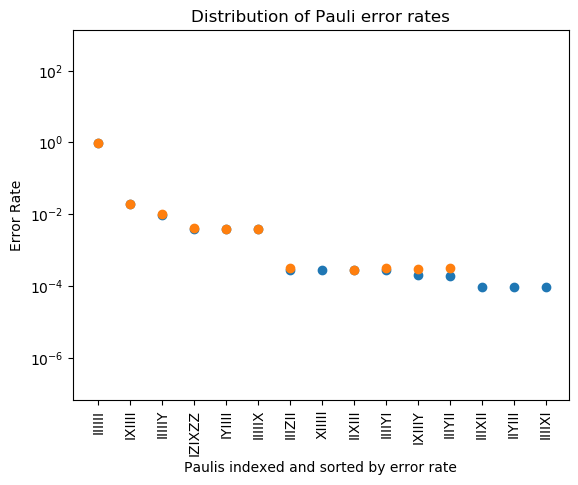

In [63]:
title("Distribution of Pauli error rates")
yscale("log")
ylabel("Error Rate")
xlabel("Paulis indexed and sorted by error rate")
indices = reverse(sortperm(dist))[1:15]
scatter(1:15,[dist[x] for x in indices])
loc = [findfirst(x->x==y,indices) for y in foundV]
scatter(loc,[found[string(x-1,base=2,pad=12)] for x in foundV])
xticks(1:15,[probabilityLabels(x-1,qubits=6) for x in indices],rotation=90);


# How will things improve if we up the shot count?



### What we will see is that the accuracy of the recovery increases, but not necessarily the number recovered.

The recovery number after a $\delta$ of 0.25 requires we up the sub-sampling groups. This is described in the paper.

In [64]:
# So we kept the actual probabilities of each of the experiments
# And now we can increase the shot statistics to see how things improve:

# 1,000 sequences of 1,000 shots
manyMoreShots = 1000000

# We need culmlative probability matrixes
cumMatrix = map(cumsum,experiment1_allProbs)
experiment1_observed = shotSimulator(64,manyMoreShots,cumMatrix);
(params,l, failed) = fitTheFidelities(lengths,experiment1_observed)
experiment1_fidelities = vcat(1,[p[2] for p in params]) # We don't fit the first one, it is always 1 for CPTP maps
#Turn those into a number...
fidelitiesExtracted = []

for x0 in paulisAll[1][3]
    p56 = binaryArrayToNumber(x0)
    for x1 in paulisAll[1][2]
        p34 = binaryArrayToNumber(x1)
        for x2 in paulisAll[1][1]
            p12= binaryArrayToNumber(x2)
            push!(fidelitiesExtracted,p56*4^4+p34*16+p12+1) # + 1 cause we index of 1 in Julia
        end
    end
end

estimateOracle = [[] for _ in 1:4096]

for i in 1:64
    push!(estimateOracle[fidelitiesExtracted[i]],experiment1_fidelities[i])
end


In [65]:
# So I am going to just do all of the above for each of the 5 (other than the one already done) for each of the qubits
e1_all_additional_fidelities = []
e1_fidelity_extracted = []
# Note we don't actually need to save the actual probabilities - but I am going to use them later
# To demonstrate some different recovery regimes.
exp_count = 1
for qubitPairOn = 1:3 # qubit pairs here are 1&2, 3&4 and 5&6
    for experimentType = 1:5
        if experiments[1][qubitPairOn][2] != experimentType
            # Its one we haven't done
            expOnFirstPair  = experiments[1][1][2]
            expOnSecondPair = experiments[1][2][2]
            expOnThirdPair  = experiments[1][3][2]

            
            if qubitPairOn == 1
                expOnFirstPair = experimentType
            elseif qubitPairOn == 2
                expOnSecondPair = experimentType
            else
                expOnThirdPair = experimentType
            end
            
            # Get the actual probabilities previously saved.
            additionalExperiment = e1_all_actualProbabilities[exp_count]
            exp_count +=1
            # Generate the measurement statistics
            cumMatrix = map(cumsum,additionalExperiment)
            experiment1_additional_observed = shotSimulator(64,manyMoreShots,cumMatrix);
            # Fit and extract the fidelities
            (params,l, failed) = fitTheFidelities(lengths,experiment1_additional_observed)
            experiment1_additional_fidelities = vcat(1,[p[2] for p in params])
            push!(e1_all_additional_fidelities,experiment1_additional_fidelities)
            fidelitiesExtracted=[]
            for x0 in all2QlMuBs[expOnThirdPair]
                p56 = binaryArrayToNumber(x0)
                for x1 in all2QlMuBs[expOnSecondPair]
                    p34 = binaryArrayToNumber(x1)
                    for x2 in all2QlMuBs[expOnFirstPair]
                        p12= binaryArrayToNumber(x2)
                        push!(fidelitiesExtracted,p56*4^4+p34*16+p12+1) # + 1 cause we index of 1 in Julia
                    end
                end
            end
            push!(e1_fidelity_extracted,fidelitiesExtracted)
        end
    end
end
# So we just need to fill in the oracle

for (expNo,x) in enumerate(e1_fidelity_extracted)
    for (fidelityIndex,fidelity)  in enumerate(x)
        push!(estimateOracle[fidelity],e1_all_additional_fidelities[expNo][fidelityIndex])
    end
end

In [66]:
# Generate shot limited stats

cumMatrix = map(cumsum,experiment2)
experiment2_observed = shotSimulator(64,manyMoreShots,cumMatrix);
# Fit and extract the fidelities
(params,l, failed) = fitTheFidelities(lengths,experiment2_observed)
experiment2_fidelities = vcat(1,[p[2] for p in params])
fidelitiesExtracted = []
for x1b in potentialSingles[experiments[2][4][2]] # Experiment 2, qubit division 3 (q1, q2&3, q4) the second part = exp number
    p6 = binaryArrayToNumber(x1b)
    for x2b in all2QlMuBs[experiments[2][3][2]]
        p45 = binaryArrayToNumber(x2b)
        for x2a in all2QlMuBs[experiments[2][2][2]]
            p23 = binaryArrayToNumber(x2a)
            for x1a in potentialSingles[experiments[2][1][2]]
                p1 = binaryArrayToNumber(x1a)
                push!(fidelitiesExtracted,p6*4^5+p45*4^3+p23*4^1+p1+1) # + 1 cause we index of 1 in Julia
             end
        end
    end
end


for (fidelityIndex,fidelity)  in enumerate(fidelitiesExtracted)
    push!(estimateOracle[fidelity],experiment2_fidelities[fidelityIndex])
end


In [67]:

e2_all_additional_fidelities = []
e2_fidelity_extracted = []
# Note here I am hard coding that we have single qubit twirls on 1 and 4.
e_count = 0
exp_count = 1
for qubitOn in 1:4 # qubits we can be "On" here are 1, 2&3 4&5 and 6
    
    if qubitOn == 2 || qubitOn == 3
        noOfExperiments = 5
    else 
        noOfExperiments = 3 # Only 3 if its a single qubit.
    end
    for experimentType = 1:noOfExperiments
        if experiments[2][qubitOn][2] != experimentType
            # Its one we haven't done
            expOnFirstSet = experiments[2][1][2]
            expOnSecondSet = experiments[2][2][2]
            expOnThirdSet = experiments[2][3][2]
            expOnFourthSet = experiments[2][4][2]


            if qubitOn == 1
                expOnFirstSet = experimentType
            elseif qubitOn == 2
                expOnSecondSet = experimentType
            elseif qubitOn ==3 
                expOnThirdSet = experimentType
            else 
                expOnFourthSet = experimentType
            end
                
            additionalExperiment = e2_all_actualProbabilities[exp_count]
            exp_count+=1
            
            # Generate the measurement statistics
            cumMatrix = map(cumsum,additionalExperiment)
            experiment2_additional_observed =  shotSimulator(64,manyMoreShots,cumMatrix);
            # Fit and extract the fidelities
            (params,l, failed) = fitTheFidelities(lengths,experiment2_additional_observed)
            experiment2_additional_fidelities = vcat(1,[p[2] for p in params])
            push!(e2_all_additional_fidelities,experiment2_additional_fidelities)
            fidelitiesExtracted=[]
            for x1 in potentialSingles[expOnFourthSet] # Experiment 2, qubit division 3 (q1, q2&3, q4&5 q6) the second part = exp number
                p6 = binaryArrayToNumber(x1)
                for x2b in all2QlMuBs[expOnThirdSet]
                    p45 = binaryArrayToNumber(x2b)
                    for x2 in all2QlMuBs[expOnSecondSet]
                        p23 = binaryArrayToNumber(x2)
                        for x3 in potentialSingles[expOnFirstSet]
                            p1 = binaryArrayToNumber(x3)
                            push!(fidelitiesExtracted,p6*4^5+p45*4^3+p23*4+p1+1) # + 1 cause we index of 1 in Julia
                        end
                     end
                end
            end
            push!(e2_fidelity_extracted,fidelitiesExtracted)
        end
    end
end

# So we just need to fill in the oracle

for (expNo,x) in enumerate(e2_fidelity_extracted)
    for (fidelityIndex,fidelity)  in enumerate(x)
        push!(estimateOracle[fidelity],e2_all_additional_fidelities[expNo][fidelityIndex])
    end
end

In [68]:
millionShotOracle = [length(x) > 0 ? mean(x) : 0 for x in estimateOracle]

4096-element Array{Real,1}:
 1.0
 0.9720104630199153
 0.9839761062969915
 0.9719892130018901
 0.9913955379703581
 0.9794129352921846
 0.9914098447964482
 0.9634084055602559
 0.9917811328544095
 0.9798149962917565
 0.9917848211807665
 0.9638389108936559
 0.9992014707775334
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [69]:
using LinearAlgebra
maxPass = 200
# singletons is when 'noise' threshold below which we declare we have found a singletons
# It will be related to the measurment accuracy and the number of bins
# Here we base it off the shotsToDo variance, on the basis of our hoped for recovery

# We start that one low and then slowly increase it, meaning we are more likely to accept
# If you have a certain probability distribution and this ansatz is not working, set it
# so that you get a reasonable number of hits in the first round.
singletons = (0.001*.999)/30000
singletonsInc = singletons/2

# Zeros is set high - we don't want to accept bins with very low numbers as they are probably just noise
# If the (sum(mean - value)^2) for all the offsets is below this number we ignore it.
# But then we lower it, meaning we are less likely to think a bin has no value in it.
# Obviously it should never be negative.
zerosC = (0.01*.999)/20000*2*1.1
zerosDec = (zerosC*0.99)/maxPass



prevFound = 0
qubitSize = 6
j6=diagm(1 => vec(hcat([[1 0] for i = 1:6]...)[1:end-1]),-1 => vec(hcat([[1 0] for i = 1:6]...)[1:end-1]))

listOfX = [[fwht_natural([millionShotOracle[x+1] for x in y]) for y in s] for s in samples]
found = Dict()
rmappings = []
for x in mappings
    if length(x) == 0
        push!(rmappings,x)
    else
        ralt = Dict()
        for i in keys(x)
            ralt[x[i]]= i
        end
        push!(rmappings,ralt)
    end
end    
prevFound = 0


for i in 1:maxPass



    for co = 1:length(listOfX)
        bucketSize = length(listOfX[co][1])
        for extractValue = 1:bucketSize
            extracted = [x[extractValue] for x in listOfX[co]]
            if !(PEEL.closeToZero(extracted,qubitSize*2,cutoff= zerosC))
               (isit,bits,val) = PEEL.checkAndExtractSingleton([extracted],qubitSize*2,cutoff=singletons)
               if isit
                  #print("$bits\n")
                  #pval = binaryArrayToNumber(j6*[x == '0' ?  0 : 1 for x in bits])
                  vval = parse(Int,bits,base=2)
                  #print("$bits, $vval $(round(dist[vval+1],digits=5)) and $(round(val,digits=5))\n")
                  PEEL.peelBack(listOfX,listOfPs,bits,val,found,ds,rmappings)
               end
            end
        end   
    end
    if length(found) > prevFound
                prevFound = length(found)
    else
        singletons += singletonsInc
        zerosC -=zerosDec 
        if (zerosC <= 0)
                break
        end
     end
     if length(found) > 0
            print("Pass $i, $(length(found)) $(sum([mean(found[x]) for x in keys(found)]))\n")
            if sum([mean(found[x]) for x in keys(found)]) >= 0.999995
                break
            end
     end


end
print("Terminated finding $(length(found)) Paulis, total of $(sum([mean(found[x]) for x in keys(found)]) ) worth of probability!\n")

Pass 1, 6 0.9979601690673886
Pass 2, 6 0.9979601690673886
Pass 3, 6 0.9979601690673886
Pass 4, 6 0.9979601690673886
Pass 5, 6 0.9979601690673886
Pass 6, 6 0.9979601690673886
Pass 7, 6 0.9979601690673886
Pass 8, 6 0.9979601690673886
Pass 9, 6 0.9979601690673886
Pass 10, 6 0.9979601690673886
Pass 11, 6 0.9979601690673886
Pass 12, 6 0.9979601690673886
Pass 13, 6 0.9979601690673886
Pass 14, 6 0.9979601690673886
Pass 15, 6 0.9979601690673886
Pass 16, 6 0.9979601690673886
Pass 17, 6 0.9979601690673886
Pass 18, 6 0.9979601690673886
Pass 19, 6 0.9979601690673886
Pass 20, 6 0.9979601690673886
Pass 21, 6 0.9979601690673886
Pass 22, 6 0.9979601690673886
Pass 23, 6 0.9979601690673886
Pass 24, 6 0.9979601690673886
Pass 25, 6 0.9979601690673886
Pass 26, 6 0.9979601690673886
Pass 27, 6 0.9979601690673886
Pass 28, 6 0.9979601690673886
Pass 29, 6 0.9979601690673886
Pass 30, 6 0.9979601690673886
Pass 31, 6 0.9979601690673886
Pass 32, 6 0.9979601690673886
Pass 33, 6 0.9979601690673886
Pass 34, 6 0.997960

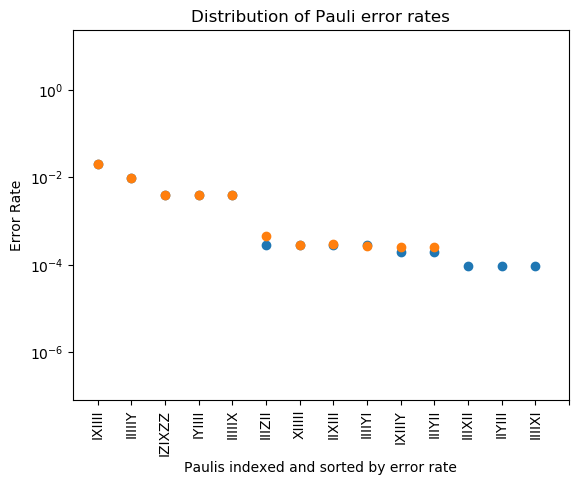

0.009729 <===> 0.009742
0.000301 <===> 0.000288
0.003995 <===> 0.004
0.003924 <===> 0.003897
0.003952 <===> 0.003937
0.000285 <===> 0.000288
0.000452 <===> 0.000288
0.019728 <===> 0.019685
0.000275 <===> 0.000288
0.956631 <===> 0.956605
0.000257 <===> 0.0002
0.000261 <===> 0.000192


In [70]:
foundV = []
for x in keys(found)
    vval = parse(Int,x,base=2)
    push!(foundV,vval+1)
    print("$(round(mean(found[x]),digits=6)) <===> $(round(dist[vval+1],digits=6))\n")
end
title("Distribution of Pauli error rates")
yscale("log")
ylabel("Error Rate")
xlabel("Paulis indexed and sorted by error rate")
indices = reverse(sortperm(dist))[2:15]
scatter(1:14,[dist[x] for x in indices])
loc = [findfirst(x->x==y,indices) for y in foundV]
scatter(loc,[found[string(x-1,base=2,pad=12)] for x in foundV])
xticks(1:15,[probabilityLabels(x-1,qubits=6) for x in indices],rotation=90);
